# Setup + Loading Data

In [7]:
# Make sure that virtual environment is working

import sys
print("Python executable:", sys.executable)


Python executable: /Users/theresahonein/Desktop/terryhonein/Research-HulaHoop/experiments/.venv/bin/python


In [8]:
# Importing packages

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import utilities_visualization
from process_movella import load_movella, get_position, lowpass_filter
from utilities_hula_hoop import get_steady_hooping_interval, get_fixed_frame_acceleration, offset_hoop_sensor, estimate_period
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FFMpegWriter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [9]:
# Defining input and output directory

IN_DIR = Path("/Users/theresahonein/Desktop/terryhonein/Research-HulaHoop/experiments/Hula Hoop/2025-09-03 Experiment 5/2025-09-03 Euler Angles/")
OUT_DIR = Path("out")

# make the output directory if it does not exist
if not OUT_DIR.exists():
    OUT_DIR.mkdir()

In [10]:
# Constants

# Hoop specifications
d = 83./100     # m, hoop diameter
r = d/2         # m, hoop radius
m = 0.25        # kg, mass of hoop

# Gravity
g = 9.81        # m/s^2, gravitational acceleration

# Time setup
f = 120         # Hz, sampling frequency
dt = 1 / f      # s, sample duration

# Inertias in corotational basis
Ixx = 0.5*m*r**2
Iyy = 0.5*m*r**2
Izz = m*r**2

In [11]:
# Reading sensor data

# OR: hoop
# OL: waist
# IB: femur
# IT: tibia
# IL: cuneiform

OR_hoop_file = IN_DIR / "OR_20250903_203926.csv"
OL_hoop_file = IN_DIR / "OL_20250903_203926.csv"
IT_hoop_file = IN_DIR / "IT_20250903_203926.csv"
IL_hoop_file = IN_DIR / "IL_20250903_203926.csv"
IB_hoop_file = IN_DIR / "IB_20250903_203926.csv"

lead_time_val = 0
OL_hoop_data = load_movella(OL_hoop_file, lead_time=lead_time_val)
OR_hoop_data = load_movella(OR_hoop_file, lead_time=lead_time_val)
IT_hoop_data = load_movella(IT_hoop_file, lead_time=lead_time_val)
IL_hoop_data = load_movella(IL_hoop_file, lead_time=lead_time_val)
IB_hoop_data = load_movella(IB_hoop_file, lead_time=lead_time_val)

time, OL_ax, OL_ay, OL_az, OL_phi, OL_theta, OL_psi, OL_wx, OL_wy, OL_wz = OL_hoop_data.T
_, OR_ax, OR_ay, OR_az, OR_phi, OR_theta, OR_psi, OR_wx, OR_wy, OR_wz = OR_hoop_data.T
_, IT_ax, IT_ay, IT_az, IT_phi, IT_theta, IT_psi, IT_wx, IT_wy, IT_wz = IT_hoop_data.T
_, IL_ax, IL_ay, IL_az, IL_phi, IL_theta, IL_psi, IL_wx, IL_wy, IL_wz = IL_hoop_data.T
_, IB_ax, IB_ay, IB_az, IB_phi, IB_theta, IB_psi, IB_wx, IB_wy, IB_wz = IB_hoop_data.T

# time step
dt = time[1]-time[0]

# Examining raw data

### angles: psi, theta, phi

In [46]:
sensor_titles = ['OR', 'OL', 'IT', 'IL', 'IB']
fig = make_subplots(rows=5, cols=1, subplot_titles=sensor_titles)
data_dict = {
    'OR': {'psi': OR_psi, 'theta': OR_theta, 'phi': OR_phi},
    'OL': {'psi': OL_psi, 'theta': OL_theta, 'phi': OL_phi},
    'IT': {'psi': IT_psi, 'theta': IT_theta, 'phi': IT_phi},
    'IL': {'psi': IL_psi, 'theta': IL_theta, 'phi': IL_phi},
    'IB': {'psi': IB_psi, 'theta': IB_theta, 'phi': IB_phi},
}
colors = {
    'psi': 'rgba(0, 0, 255, 0.7)',    # Blue
    'theta': 'rgba(255, 0, 0, 0.7)',  # Red
    'phi': 'rgba(0, 128, 0, 0.7)'     # Green
}

# Keep track of which legend items have been shown
legend_shown = {'psi': False, 'theta': False, 'phi': False}

# Loop through each sensor and subplot
for i, sensor in enumerate(sensor_titles, start=1):
    for angle_type, color in colors.items():
        fig.add_trace(go.Scatter(
            x=time, 
            y=data_dict[sensor][angle_type], 
            mode='lines', 
            name=f'{angle_type.capitalize()}',
            legendgroup=f'{angle_type}',
            line=dict(color=color),
            showlegend=not legend_shown[angle_type]
        ), row=i, col=1)
        # Mark this legend item as shown after the first trace
        legend_shown[angle_type] = True

# Decrease margins and add a title
fig.update_layout(
    height=800,width=800,
    title_text="Raw Euler Angle Data",
    margin=dict(l=40, r=20, t=80, b=40),
)
fig.show()

### angular velocities: wx, wy, wz

In [13]:
sensor_titles = ['OR', 'OL', 'IT', 'IL', 'IB'] 

fig = make_subplots(rows=5, cols=1, subplot_titles=sensor_titles) 
data_dict = {
    'OR': {'wx': OR_wx, 'wy': OR_wy, 'wz': OR_wz}, 
    'OL': {'wx': OL_wx, 'wy': OL_wy, 'wz': OL_wz}, 
    'IT': {'wx': IT_wx, 'wy': IT_wy, 'wz': IT_wz}, 
    'IL': {'wx': IL_wx, 'wy': IL_wy, 'wz': IL_wz}, 
    'IB': {'wx': IB_wx, 'wy': IB_wy, 'wz': IB_wz}, 
} 

colors = { 
    'wx': 'rgba(0, 0, 255, 0.7)', # Blue 
    'wy': 'rgba(255, 0, 0, 0.7)', # Red 
    'wz': 'rgba(0, 128, 0, 0.7)' # Green 
} 
y_limits = {
    'OR': [-10, 5],
    'OL': [-5, 5],
    'IT': [-5, 5],
    'IL': [-5, 5],
    'IB': [-5, 5],
}

# Keep track of which legend items have been shown 
legend_shown = {'wx': False, 'wy': False, 'wz': False} 

# Loop through each sensor and subplot 
for i, sensor in enumerate(sensor_titles, start=1): 
    for angle_type, color in colors.items(): 
        fig.add_trace(go.Scatter( 
            x=time, 
            y=data_dict[sensor][angle_type], 
            mode='lines', 
            name=f'{angle_type.capitalize()}', 
            legendgroup=f'{angle_type}', 
            line=dict(color=color), 
            showlegend=not legend_shown[angle_type] ), 
            row=i, 
            col=1) 
        # Mark this legend item as shown after the first trace 
        legend_shown[angle_type] = True

    # set y-axis range for this subplot
    fig.update_yaxes(range=y_limits[sensor], row=i, col=1)
        
# Decrease margins and add a title 
fig.update_layout( 
    height=800,
    width=800, 
    title_text="Raw Angular Velocities", 
    margin=dict(l=40, r=20, t=80, b=40), 
) 
fig.show()

### raw accelerations: ax, ay, az

In [14]:
sensor_titles = ['OR', 'OL', 'IT', 'IL', 'IB']
fig = make_subplots(rows=5, cols=1, subplot_titles=sensor_titles)
data_dict = {
    'OR': {'ax': OR_ax, 'ay': OR_ay, 'az': OR_az},
    'OL': {'ax': OL_ax, 'ay': OL_ay, 'az': OL_az},
    'IT': {'ax': IT_ax, 'ay': IT_ay, 'az': IT_az},
    'IL': {'ax': IL_ax, 'ay': IL_ay, 'az': IL_az},
    'IB': {'ax': IB_ax, 'ay': IB_ay, 'az': IB_az},
}
colors = {
    'ax': 'rgba(0, 0, 255, 0.7)',    # Blue
    'ay': 'rgba(255, 0, 0, 0.7)',  # Red
    'az': 'rgba(0, 128, 0, 0.7)'     # Green
}
y_limits = {
    'OR': [-100, 100],
    'OL': [-10, 10],
    'IT': [-10, 10],
    'IL': [-10, 10],
    'IB': [-10, 10],
}

# Keep track of which legend items have been shown
legend_shown = {'ax': False, 'ay': False, 'az': False}

# Loop through each sensor and subplot
for i, sensor in enumerate(sensor_titles, start=1):
    for angle_type, color in colors.items():
        fig.add_trace(go.Scatter(
            x=time, 
            y=data_dict[sensor][angle_type], 
            mode='lines', 
            name=f'{angle_type.capitalize()}',
            legendgroup=f'{angle_type}',
            line=dict(color=color),
            showlegend=not legend_shown[angle_type]
        ), row=i, col=1)
        # Mark this legend item as shown after the first trace
        legend_shown[angle_type] = True

    # set y-axis range for this subplot
    fig.update_yaxes(range=y_limits[sensor], row=i, col=1)

# Decrease margins and add a title
fig.update_layout(
    height=800,width=800,
    title_text="Raw Accelerations",
    margin=dict(l=40, r=20, t=80, b=40),
)
fig.show()

# Finding interval of steady hula hooping

We can detect when steady hula hoop motion is happening by looking at the psi-dot time series. psi is almost constant during steady hula hooping. You see how initially the hula hooper turns the hoop opposite to the directions at which it will rotate, then gives a high initial angular velocity. The initial angular velocity psidot will be sustained by the hoop until failure.

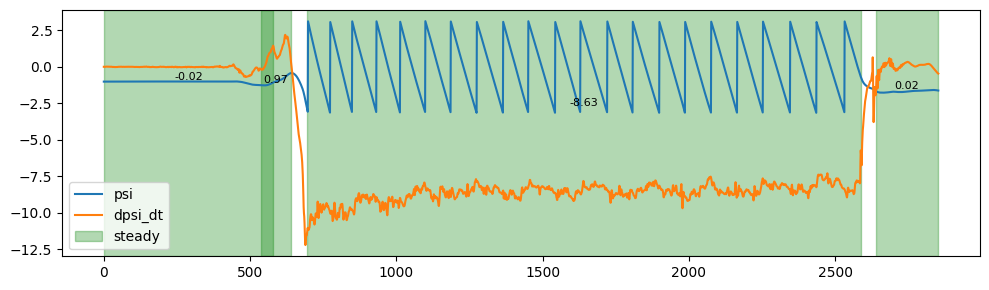

In [15]:
OR_groups, OR_averages = get_steady_hooping_interval(OR_psi, dt=dt, threshold=0.55)

In [16]:
OR_groups

[(np.int64(0), np.int64(578)),
 (np.int64(538), np.int64(640)),
 (np.int64(694), np.int64(2587)),
 (np.int64(2639), np.int64(2852))]

In [17]:
OR_averages

[np.float64(-0.016012615498467945),
 np.float64(0.9702579643553674),
 np.float64(-8.630305533323602),
 np.float64(0.024618983310848642)]

In [18]:
active_slice = np.arange(694, 2588)

# PCA on angular velocities
Reproducing the results from 'Coordination modes in the multisegmental dynamics of hula hooping' by Balasubramanian and Turvey published in 2004.

Main results
- Karhunen-Loeve decomposition was applied to the kinematics of the lower limbs
- Kinematic variance was accomodated by two modes whose relative contributions varied with task paramters.

Which data should we run into PCA: raw or smooth?

shape(X):
(1894, 9)
X_pca:
[[-3.30555739  1.18007238 -0.23994333 ... -1.34071599  0.50247279
  -0.38924671]
 [-3.61926992  1.01031752 -0.27440964 ... -1.47423057  0.52557506
  -0.53428691]
 [-3.76075919  0.69481611 -0.28970501 ... -1.4860545   0.49704856
  -0.60552597]
 ...
 [-0.75809107 -1.29743063 -0.84354711 ... -0.65147724 -0.97081537
   0.07564867]
 [-0.97892724 -1.12848881 -0.9711935  ... -0.65340345 -0.92525703
   0.10042993]
 [-1.15479462 -0.94478847 -1.08771075 ... -0.64957039 -0.84315286
   0.14409732]]
Eigenvalues:
[4.31222564 2.5692545  0.85960723 0.45246508 0.34342852 0.16634979
 0.15874094 0.09522168 0.04746098]
Eigenvectors (Principal Directions):
[[ 0.42257281 -0.08068814  0.36619361  0.33897732  0.32195902  0.41464309
  -0.40125117  0.06771503  0.35319107]
 [-0.22347293  0.50671742 -0.32005579 -0.23339501  0.4025964  -0.00308158
  -0.15964041  0.51090855  0.29628097]
 [ 0.16304415  0.11720914  0.23463818  0.53393066  0.05666941 -0.43065109
   0.46631655  0.46107883 -0.

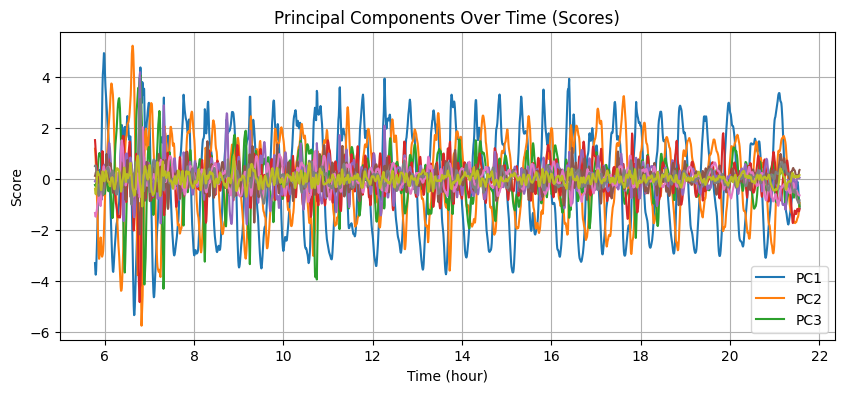

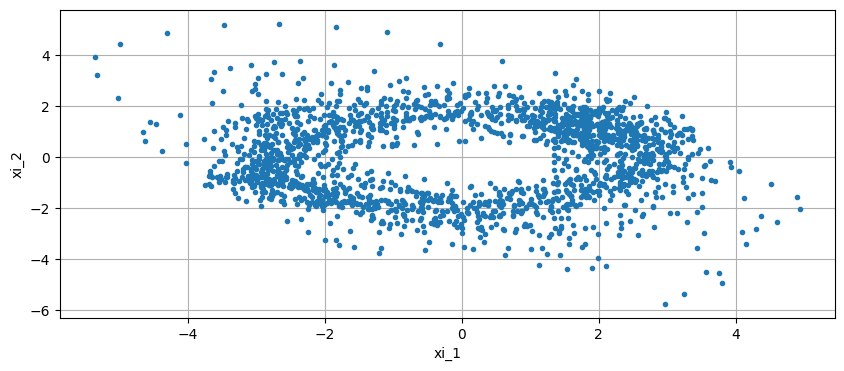

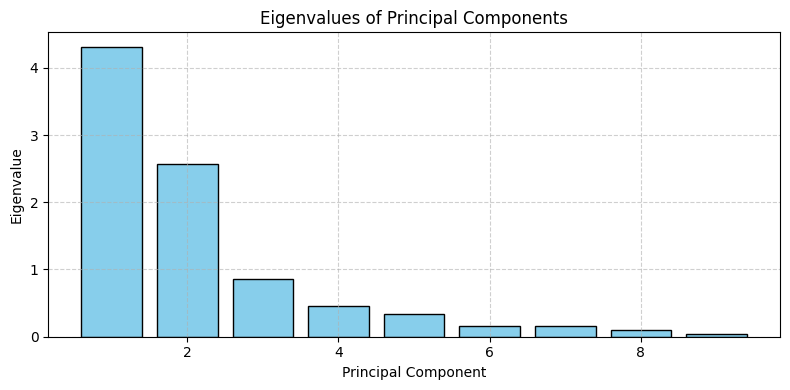

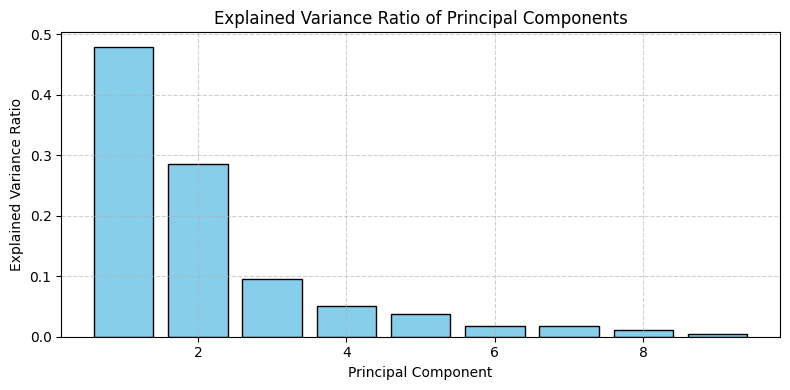

In [35]:
# Step 1: Stack and transpose
X = np.vstack([
    IB_wx[active_slice], IB_wy[active_slice], IB_wz[active_slice],
    IT_wx[active_slice], IT_wy[active_slice], IT_wz[active_slice],
    IL_wx[active_slice], IL_wy[active_slice], IL_wz[active_slice],
    ]).T

print('shape(X):')
print(np.shape(X))

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA
pca = PCA(n_components=np.shape(X)[1])
X_pca = pca.fit_transform(X_scaled)
# Get the eigenvectors (principal directions)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_

# After fitting PCA

print('X_pca:')
print(X_pca)

print("Eigenvalues:")
print(eigenvalues)

print("Eigenvectors (Principal Directions):")
print(eigenvectors)

# Explained variance ratio
print("Explained Variance Ratio:")
print(explained_variance_ratio)


plt.figure(figsize=(10, 4))
plt.plot(time[active_slice], X_pca)
plt.title("Principal Components Over Time (Scores)")
plt.legend(["PC1", "PC2", "PC3"])
plt.xlabel("Time (hour)")
plt.ylabel("Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(X_pca[:,0],X_pca[:,1],'.')
plt.xlabel("xi_1")
plt.ylabel("xi_2")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, color='skyblue', edgecolor='k')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of Principal Components')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(eigenvalues) + 1), explained_variance_ratio, color='skyblue', edgecolor='k')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

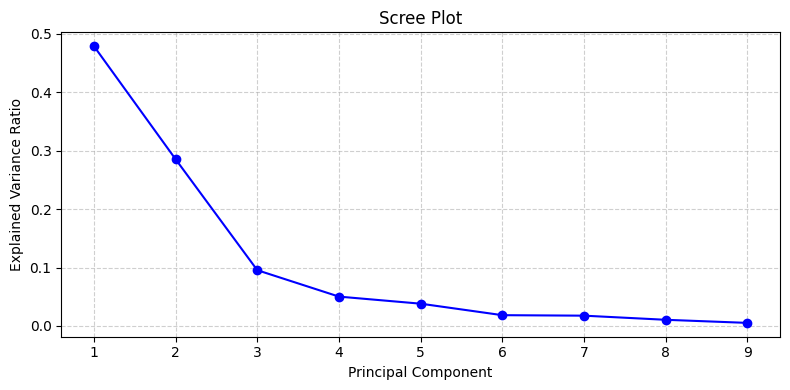

In [20]:
# Plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'o-', color='blue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

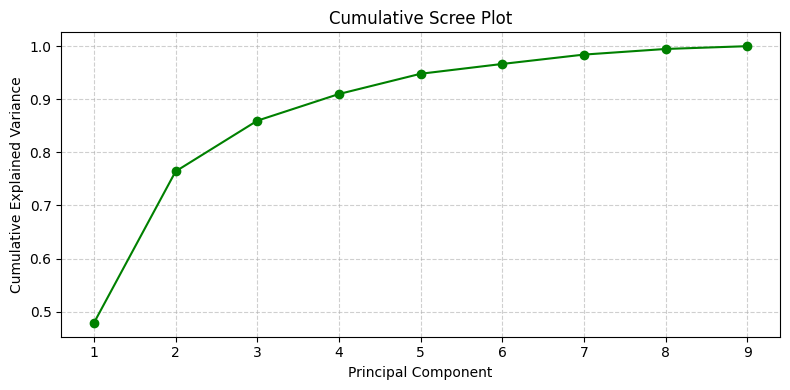

In [21]:
cumulative_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', color='green')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Scree Plot')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

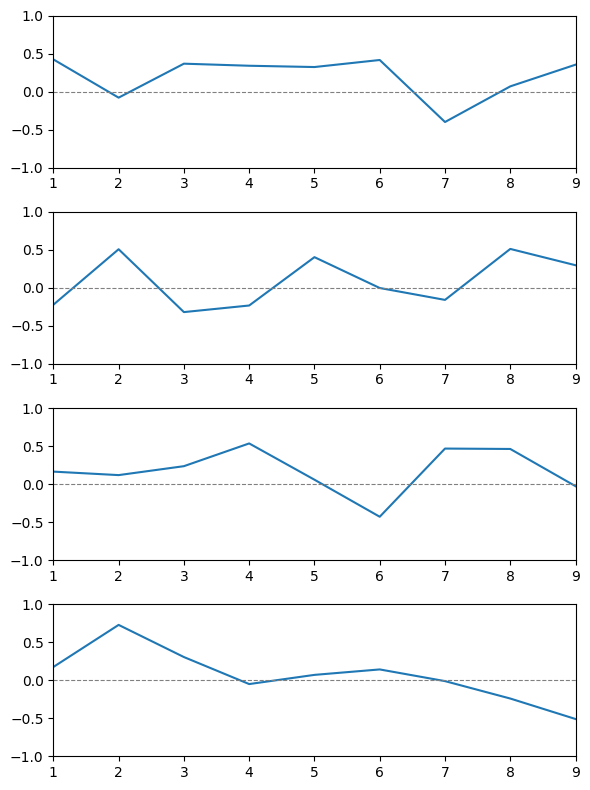

In [22]:
n_rows, n_cols = eigenvectors.shape

n_rows = 4 # overriding, printing top 4 only

fig, ax = plt.subplots(n_rows, 1, figsize=(6, 8))
x_vals = np.arange(1, n_cols + 1)  # X values starting from 1

for i in range(n_rows):
    ax[i].plot(x_vals, eigenvectors[i, :])
    ax[i].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax[i].set_xticks(x_vals)
    ax[i].set_xticklabels([f"{x}" for x in x_vals])  # TikZ-style labels: 1, 2, ...
    ax[i].set_xlim(1, n_cols)
    ax[i].set_ylim(-1, 1)

plt.tight_layout()

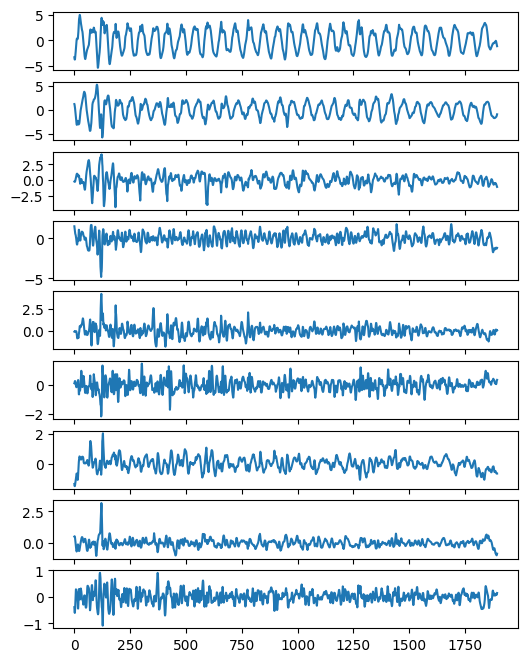

In [23]:
n = X_pca.shape[1]
fig, ax = plt.subplots(n,1,figsize=(6, 8))
for i in range(n):
    ax[i].plot(X_pca[:,i]) 

In [59]:
n = X_pca.shape[1]

period_fft = np.zeros(n)
period_psd = np.zeros(n)
period_srim = np.zeros(n)

for i in range(n):

    period_fft[i] = estimate_period(X_pca[:,i], method='fft', plot=False)
    period_psd[i] = estimate_period(X_pca[:,i], method='psd', plot=False)
    period_srim[i] = estimate_period(X_pca[:,i], method='srim', plot=False)

print(f"{period_fft=}")
print(f"{period_psd=}")
print(f"{period_srim=}")


period_fft=array([0.50913978, 0.50913978, 0.50913978, 0.1679078 , 0.2505291 ,
       0.25456989, 0.25456989, 0.32881944, 0.22874396])
period_psd=array([0.50913978, 0.50913978, 0.50913978, 0.1679078 , 0.2505291 ,
       0.25456989, 0.25456989, 0.32881944, 0.22874396])
period_srim=array([0.50820917, 0.50881269, 0.34358922, 0.16826248, 0.25430013,
       0.25478872, 0.25109668, 0.37960778, 0.23304468])


Read `Daffertshofer et al. PCA in studying coordination and variability: a tutorial` figures 7 and 4. According to these authors, the similar periods could be hinting at oscillations under holonomic constraints. That is, the signals might be functionally related (eg. deffering by a phase) rather than totally independent.

PCA might not be the best method to analyze constrained systems: [see what ChatGPT says about this](https://chatgpt.com/share/688979e2-0ef0-8011-97f9-e46adb3f0616)

Other techniques: 
- Constrained Principal Component Analysis: not very well suited. Read more.
- Network Analysis: https://scholar.google.com/citations?user=_VF_KCQAAAAJ&hl=en&oi=ao

# with hoop

shape(X):
(1894, 15)
X_pca:
[[ 3.47400295e+00  1.47780307e+00 -2.45845523e+00 ... -9.26075764e-02
   6.67803655e-01 -2.08275188e-01]
 [ 3.80648934e+00  1.38550402e+00 -2.56339635e+00 ... -1.43472899e-01
   7.76752878e-01 -3.46782819e-01]
 [ 3.99161069e+00  1.11698615e+00 -2.54390900e+00 ... -1.97857040e-01
   8.14988345e-01 -4.20997565e-01]
 ...
 [ 8.89197110e-01 -1.25220766e+00  1.58135508e+00 ... -8.38722360e-01
  -5.75868379e-01 -8.43063967e-04]
 [ 1.01244195e+00 -1.01813897e+00  1.82294189e+00 ... -7.52812758e-01
  -6.26252465e-01  1.98790381e-03]
 [ 1.14223298e+00 -9.70852553e-01  4.15267810e+00 ... -6.35721927e-01
  -5.20882996e-01 -1.13139125e-02]]
Eigenvalues:
[5.25177806 2.95518268 1.20889336 1.03304935 0.94762201 0.86989552
 0.84978218 0.54321455 0.44848861 0.32812793 0.18257689 0.16223969
 0.10308428 0.0789051  0.04508371]
Eigenvectors (Principal Directions):
[[-3.53964606e-01  2.22396908e-02 -2.94907870e-01 -2.74515682e-01
  -3.25584777e-01 -3.77205658e-01  3.74278292e-01 -

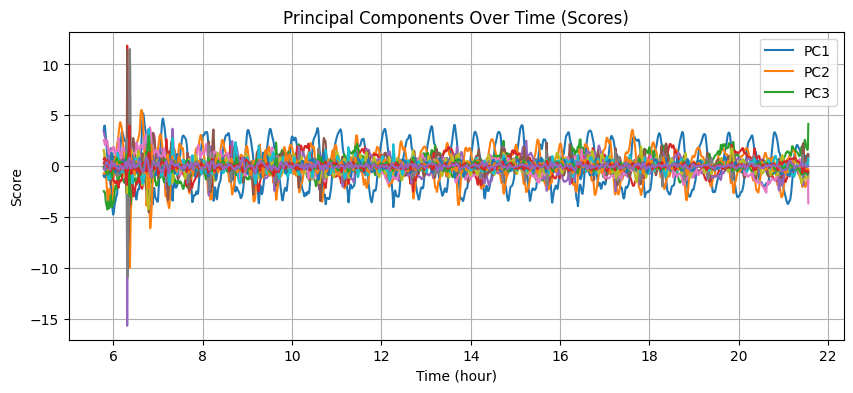

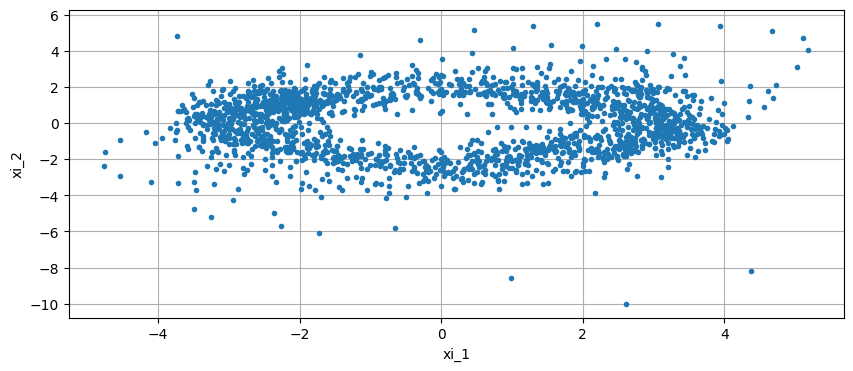

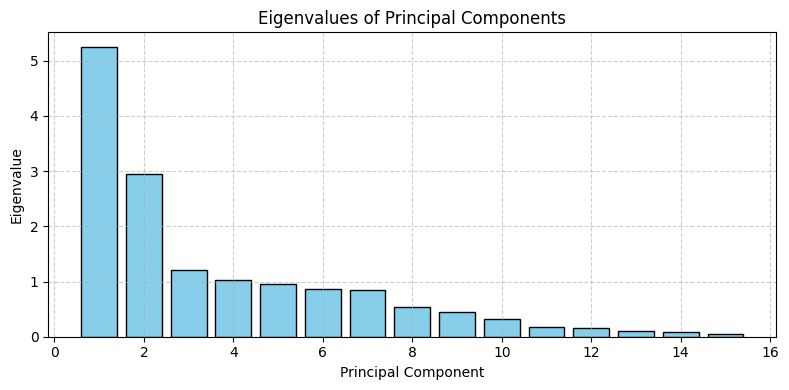

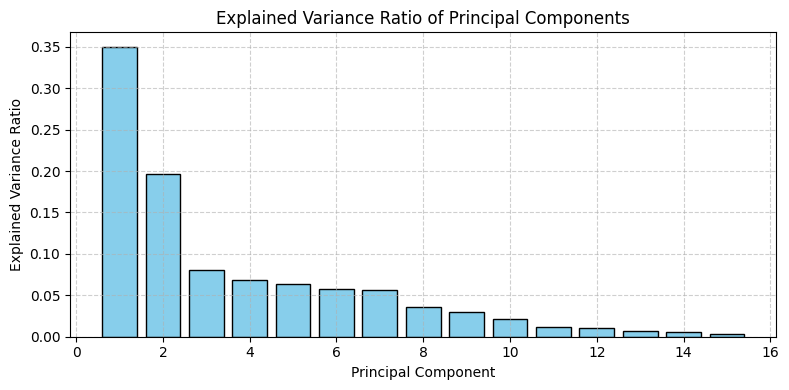

In [67]:
# Step 1: Stack and transpose
X = np.vstack([
    IB_wx[active_slice], IB_wy[active_slice], IB_wz[active_slice],
    IT_wx[active_slice], IT_wy[active_slice], IT_wz[active_slice],
    IL_wx[active_slice], IL_wy[active_slice], IL_wz[active_slice],
    OL_wx[active_slice], OL_wy[active_slice], OL_wz[active_slice],
    OR_wx[active_slice], OR_wy[active_slice], OR_wz[active_slice]
    ]).T

print('shape(X):')
print(np.shape(X))

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA
pca = PCA(n_components=np.shape(X)[1])
X_pca = pca.fit_transform(X_scaled)
# Get the eigenvectors (principal directions)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_

# After fitting PCA

print('X_pca:')
print(X_pca)

print("Eigenvalues:")
print(eigenvalues)

print("Eigenvectors (Principal Directions):")
print(eigenvectors)

# Explained variance ratio
print("Explained Variance Ratio:")
print(explained_variance_ratio)


plt.figure(figsize=(10, 4))
plt.plot(time[active_slice], X_pca)
plt.title("Principal Components Over Time (Scores)")
plt.legend(["PC1", "PC2", "PC3"])
plt.xlabel("Time (hour)")
plt.ylabel("Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(X_pca[:,0],X_pca[:,1],'.')
plt.xlabel("xi_1")
plt.ylabel("xi_2")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, color='skyblue', edgecolor='k')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of Principal Components')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(eigenvalues) + 1), explained_variance_ratio, color='skyblue', edgecolor='k')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Exporting data for network calculations

In [26]:
data = np.vstack((OL_ax[active_slice], OL_ay[active_slice], OL_az[active_slice], OL_phi[active_slice], OL_theta[active_slice], OL_psi[active_slice], OL_wx[active_slice], OL_wy[active_slice], OL_wz[active_slice],
                  OR_ax[active_slice], OR_ay[active_slice], OR_az[active_slice], OR_phi[active_slice], OR_theta[active_slice], OR_psi[active_slice], OR_wx[active_slice], OR_wy[active_slice], OR_wz[active_slice],
                  IT_ax[active_slice], IT_ay[active_slice], IT_az[active_slice], IT_phi[active_slice], IT_theta[active_slice], IT_psi[active_slice], IT_wx[active_slice], IT_wy[active_slice], IT_wz[active_slice],
                  IL_ax[active_slice], IL_ay[active_slice], IL_az[active_slice], IL_phi[active_slice], IL_theta[active_slice], IL_psi[active_slice], IL_wx[active_slice], IL_wy[active_slice], IL_wz[active_slice],
                  IB_ax[active_slice], IB_ay[active_slice], IB_az[active_slice], IB_phi[active_slice], IB_theta[active_slice], IB_psi[active_slice], IB_wx[active_slice], IB_wy[active_slice], IB_wz[active_slice]))

np.save("data.npy", data)

In [27]:
data = np.vstack((OL_wx[active_slice], OL_wy[active_slice], OL_wz[active_slice],
                  OR_wx[active_slice], OR_wy[active_slice], OR_wz[active_slice],
                  IT_wx[active_slice], IT_wy[active_slice], IT_wz[active_slice],
                  IL_wx[active_slice], IL_wy[active_slice], IL_wz[active_slice],
                  IB_wx[active_slice], IB_wy[active_slice], IB_wz[active_slice]))

np.save("data.npy", data)

In [28]:
np.shape(data)

(15, 1894)

# Plotting raw angles and their derivatives

In [29]:
sensor_titles = ['OR', 'OL', 'IT', 'IL', 'IB']
fig = make_subplots(rows=5, cols=1, subplot_titles=sensor_titles)
data_dict = {
    'OR': {'psi': OR_psi, 'theta': OR_theta, 'phi': OR_phi},
    'OL': {'psi': OL_psi, 'theta': OL_theta, 'phi': OL_phi},
    'IT': {'psi': IT_psi, 'theta': IT_theta, 'phi': IT_phi},
    'IL': {'psi': IL_psi, 'theta': IL_theta, 'phi': IL_phi},
    'IB': {'psi': IB_psi, 'theta': IB_theta, 'phi': IB_phi},
}
colors = {
    'psi': 'rgba(0, 0, 255, 0.7)',    # Blue
    'theta': 'rgba(255, 0, 0, 0.7)',  # Red
    'phi': 'rgba(0, 128, 0, 0.7)'     # Green
}

# Keep track of which legend items have been shown
legend_shown = {'psi': False, 'theta': False, 'phi': False}

# Loop through each sensor and subplot
for i, sensor in enumerate(sensor_titles, start=1):
    for angle_type, color in colors.items():
        fig.add_trace(go.Scatter(
            x=time[active_slice], 
            y=data_dict[sensor][angle_type][active_slice], 
            mode='lines', 
            name=f'{angle_type.capitalize()}',
            legendgroup=f'{angle_type}',
            line=dict(color=color),
            showlegend=not legend_shown[angle_type]
        ), row=i, col=1)
        # Mark this legend item as shown after the first trace
        legend_shown[angle_type] = True

# Decrease margins and add a title
fig.update_layout(
    height=800,width=800,
    title_text="Raw Euler Angle Data",
    margin=dict(l=40, r=20, t=80, b=40),
)
fig.show()

What does the 3-2-1 Euler angle set look like for the hip? Does it make sense that theta is almost zero? Yes. See [video](https://www.youtube.com/watch?v=UpSMNYTVqQI)

In [30]:
sensors = ['IT', 'IL', 'IB']
fig_th = make_subplots(
    rows=3, 
    cols=1, 
    subplot_titles=sensors,
)
theta_data = {
    'IT': IT_theta,
    'IL': IL_theta,
    'IB': IB_theta,
}

# Loop through each sensor and add a trace
for i, sensor in enumerate(sensors, start=1):
    fig_th.add_trace(go.Scatter(
        x=time[active_slice],
        y=theta_data[sensor][active_slice],
        mode='lines',
        name=f'{sensor}_theta',
    ), row=i, col=1)
fig_th.update_yaxes(range=[-1.8, -1.0])

fig_th.update_layout(
    height=500,width=800,
    title_text="Theta of Hip",
    margin=dict(l=40, r=20, t=80, b=40)
)
fig_th.show()

In [31]:
# Derivatives of psi and phi of hip

IT_psi_unwrapped = np.unwrap(IT_psi)
IL_psi_unwrapped = np.unwrap(IL_psi)
IB_psi_unwrapped = np.unwrap(IB_psi)

IT_theta_unwrapped = np.unwrap(IT_theta)
IL_theta_unwrapped = np.unwrap(IL_theta)
IB_theta_unwrapped = np.unwrap(IB_theta)

IT_phi_unwrapped = np.unwrap(IT_phi)
IL_phi_unwrapped = np.unwrap(IL_phi)
IB_phi_unwrapped = np.unwrap(IB_phi)

IT_dpsi_dt = np.gradient(IT_psi_unwrapped, dt)
IL_dpsi_dt = np.gradient(IL_psi_unwrapped, dt)
IB_dpsi_dt = np.gradient(IB_psi_unwrapped, dt)

IT_dtheta_dt = np.gradient(IT_theta_unwrapped, dt)
IL_dtheta_dt = np.gradient(IL_theta_unwrapped, dt)
IB_dtheta_dt = np.gradient(IB_theta_unwrapped, dt)

IT_dphi_dt = np.gradient(IT_phi_unwrapped, dt)
IL_dphi_dt = np.gradient(IL_phi_unwrapped, dt)
IB_dphi_dt = np.gradient(IB_phi_unwrapped, dt)

sensors = ['IT', 'IL', 'IB']
angle_types = ['dpsi_dt', 'dtheta_dt', 'dphi_dt']
subplot_titles = [f'{s}_{a}' for a in angle_types for s in sensors]

fig_dhip = make_subplots(
    rows=9, 
    cols=1, 
    subplot_titles=subplot_titles
)

data_dict = {
    'IT': {'dpsi_dt': IT_dpsi_dt, 'dtheta_dt': IT_dtheta_dt, 'dphi_dt': IT_dphi_dt},
    'IL': {'dpsi_dt': IL_dpsi_dt, 'dtheta_dt': IL_dtheta_dt, 'dphi_dt': IL_dphi_dt},
    'IB': {'dpsi_dt': IB_dpsi_dt, 'dtheta_dt': IB_dtheta_dt, 'dphi_dt': IB_dphi_dt},
}

derivative_colors = {
    'dpsi_dt': 'rgba(0, 0, 255, 0.7)',
    'dtheta_dt': 'rgba(255, 0, 0, 0.7)',
    'dphi_dt': 'rgba(0, 128, 0, 0.7)'
}

legend_shown = {angle: False for angle in angle_types}

i = 1
for angle_type in angle_types:
    for sensor in sensors:
        fig_dhip.add_trace(go.Scatter(
            x=time[active_slice],
            y=data_dict[sensor][angle_type][active_slice],
            mode='lines',
            name=f'{angle_type}',
            legendgroup=f'{angle_type}',
            line=dict(color=derivative_colors[angle_type]),
            showlegend=not legend_shown[angle_type]
        ), row=i, col=1)
        
        legend_shown[angle_type] = True
        i += 1

fig_dhip.update_layout(
    height=1200,
    width=800,
    title_text="Derivative of Euler Angles",
    margin=dict(l=40, r=20, t=80, b=40),
)

fig_dhip.show()

For the signals on the upper hip (belt), you see bursts of fast motion of the angles psi and phi. The rest of the motion is slow. This is evidenced by the derivatives. Lower hip data looks different.

In the paper `Kinetics of hula hooping: An inverse dynamics analysis by Cluff et al. (2008)`, the authors discuss in their results that there were substantial asychronous abductor moments observed about the hip for both the left and right legs. The abductor moments produced large bursts of positive and negative work making the abductor moment the prime mover during hula hooping.

Our data does not substantiate this result. See the next plot.

In [32]:
# Derivatives of psi and phi of hip

sensors = ['IT', 'IL', 'IB']
angular_velocity = ['wx', 'wy', 'wz']
subplot_titles = [f'{s}_{a}' for a in angular_velocity for s in sensors]

fig_dhip = make_subplots(
    rows=9, 
    cols=1, 
    subplot_titles=subplot_titles
)

data_dict = {
    'IT': {'wx': IT_wx, 'wy': IT_wy, 'wz': IT_wz},
    'IL': {'wx': IL_wx, 'wy': IL_wy, 'wz': IL_wz},
    'IB': {'wx': IB_wx, 'wy': IB_wy, 'wz': IB_wz},
}

derivative_colors = {
    'wx': 'rgba(0, 0, 255, 0.7)',
    'wy': 'rgba(255, 0, 0, 0.7)',
    'wz': 'rgba(0, 128, 0, 0.7)'
}

legend_shown = {angle: False for angle in angular_velocity}

i = 1
for angle_type in angular_velocity:
    for sensor in sensors:
        fig_dhip.add_trace(go.Scatter(
            x=time[active_slice],
            y=data_dict[sensor][angle_type][active_slice],
            mode='lines',
            name=f'{angle_type}',
            legendgroup=f'{angle_type}',
            line=dict(color=derivative_colors[angle_type]),
            showlegend=not legend_shown[angle_type]
        ), row=i, col=1)
        
        legend_shown[angle_type] = True
        i += 1

fig_dhip.update_layout(
    height=1200,
    width=800,
    title_text="Derivative of Euler Angles",
    margin=dict(l=40, r=20, t=80, b=40),
)

fig_dhip.show()

# Acceleration

In [36]:
sensors = ['OR', 'OL', 'IT']
fig_ra = make_subplots(
    rows=3, 
    cols=1, 
    subplot_titles=sensors
)

data_dict = {
    'OR': {'x': OR_ax, 'y': OR_ay, 'z': OR_az},
    'OL': {'x': OL_ax, 'y': OL_ay, 'z': OL_az},
    'IT': {'x': IT_ax, 'y': IT_ay, 'z': IT_az},
}

colors = {
    'x': 'rgba(255, 0, 0, 0.7)',   # Red for x
    'y': 'rgba(0, 128, 0, 0.7)',   # Green for y
    'z': 'rgba(0, 0, 255, 0.7)',   # Blue for z
    'xy': 'rgba(128, 0, 128, 0.7)' # Purple for xy magnitude
}

legend_shown = {'x': False, 'y': False, 'z': False, 'xy': False}

for i, sensor in enumerate(sensors, start=1):
    for axis, color in colors.items():
        if axis != 'xy':
            fig_ra.add_trace(go.Scatter(
                x=time,
                y=data_dict[sensor][axis],
                mode='lines',
                name=f'Accel_{axis}',
                legendgroup=f'accel_{axis}',
                line=dict(color=color, width=1),
                showlegend=not legend_shown[axis]
            ), row=i, col=1)
            legend_shown[axis] = True

    # Plot the magnitude of the xy components
    # OR_accel_xy = np.sqrt(OR_accel_x**2 + OR_accel_y**2)
    # OL_accel_xy = np.sqrt(OL_accel_x**2 + OL_accel_y**2)
    # IT_accel_xy = np.sqrt(IT_accel_x**2 + IT_accel_y**2)
    # xy_data = {'OR': OR_accel_xy, 'OL': OL_accel_xy, 'IT': IT_accel_xy}
    
    # if not legend_shown['xy']:
    #     fig_ra.add_trace(go.Scatter(
    #         x=time,
    #         y=xy_data[sensor],
    #         mode='lines',
    #         name='Accel_xy',
    #         legendgroup='accel_xy',
    #         line=dict(color=colors['xy'], width=1),
    #         showlegend=True
    #     ), row=i, col=1)
    #     legend_shown['xy'] = True
    # else:
    #     fig_ra.add_trace(go.Scatter(
    #         x=time,
    #         y=xy_data[sensor],
    #         mode='lines',
    #         name='Accel_xy',
    #         legendgroup='accel_xy',
    #         line=dict(color=colors['xy'], width=1),
    #         showlegend=False
    #     ), row=i, col=1)

fig_ra.update_layout(
    height=500,
    width=800,
    title_text="Raw Acceleration Data",
    margin=dict(l=40, r=20, t=80, b=40),
)

fig_ra.show()

OR and OL accelerations period. accel_x and accel_z have same frequency. accel_y has double the frequency.

[be careful! how is the sensor oriented?] At the minimum value of az, that's the point when the sensor is being pushed up. Both sensors should read the same signal, but shifted. The shift can be adjusted by aligning the local minimza of az.

## Determining acceleration components in fixed basis & integrating to find displacement

In [37]:
OR_Ax, OR_Ay, OR_Az = get_fixed_frame_acceleration(OR_ax, OR_ay, OR_az, OR_psi, OR_theta, OR_phi)
OL_Ax, OL_Ay, OL_Az = get_fixed_frame_acceleration(OL_ax, OL_ay, OL_az, OL_psi, OL_theta, OL_phi)
IT_Ax, IT_Ay, IT_Az = get_fixed_frame_acceleration(IT_ax, IT_ay, IT_az, IT_psi, IT_theta, IT_phi)
IL_Ax, IL_Ay, IL_Az = get_fixed_frame_acceleration(IL_ax, IL_ay, IL_az, IL_psi, IL_theta, IL_phi)
IB_Ax, IB_Ay, IB_Az = get_fixed_frame_acceleration(IB_ax, IB_ay, IB_az, IB_psi, IB_theta, IB_phi)


In [38]:
sensors = ['OR', 'OL', 'IT']
fig_ra = make_subplots(
    rows=3,
    cols=1,
    subplot_titles=sensors
)
data_dict = {
    'OR': {'x': OR_Ax, 'y': OR_Ay, 'z': OR_Az},
    'OL': {'x': OL_Ax, 'y': OL_Ay, 'z': OL_Az},
    'IT': {'x': IT_Ax, 'y': IT_Ay, 'z': IT_Az},
}
colors = {
    'x': 'rgba(255, 0, 0, 0.8)',
    'y': 'rgba(0, 128, 0, 0.8)',
    'z': 'rgba(0, 0, 255, 0.8)',
    'xy_mag': 'rgba(128, 0, 128, 0.8)'
}
legend_shown = {'x': False, 'y': False, 'z': False, 'xy_mag': False}

for i, sensor in enumerate(sensors, start=1):
    for axis in ['x', 'y', 'z']:
        fig_ra.add_trace(go.Scatter(
            x=time,
            y=data_dict[sensor][axis],
            mode='lines',
            name=f'Accel_{axis}',
            legendgroup=f'accel_{axis}',
            line=dict(color=colors[axis], width=1),
            showlegend=not legend_shown[axis]
        ), row=i, col=1)
        legend_shown[axis] = True

    xy_mag = np.sqrt(data_dict[sensor]['x']**2 + data_dict[sensor]['y']**2)
    
    fig_ra.add_trace(go.Scatter(
        x=time,
        y=xy_mag,
        mode='lines',
        name='Accel_xy',
        legendgroup='accel_xy_mag',
        line=dict(color=colors['xy_mag'], width=1),
        showlegend=not legend_shown['xy_mag']
    ), row=i, col=1)
    legend_shown['xy_mag'] = True

fig_ra.update_layout(
    height=500,
    width=800,
    title_text="Raw Acceleration Data in Fixed Basis",
    margin=dict(l=40, r=20, t=80, b=40),
)

fig_ra.show()

We are detrending the results everytime we integrate. Explain why. Any effect on results?

In [43]:
print(np.shape(time))
print(np.shape(OR_Ax))
print(np.shape(OR_Ay))
print(np.shape(OR_Az))

(2853,)
(2853,)
(2853,)
(2853,)


In [55]:
OR_dx, OR_dy, OR_dz, OR_vx, OR_vy, OR_vz = get_position(time[active_slice],OR_Ax[active_slice], OR_Ay[active_slice], OR_Az[active_slice], degree=5, initial=0)
OL_dx, OL_dy, OL_dz, OL_vx, OL_vy, OL_vz = get_position(time[active_slice],OL_Ax[active_slice], OL_Ay[active_slice], OL_Az[active_slice], degree=5, initial=0)
IT_dx, IT_dy, IT_dz, IT_vx, IT_vy, IT_vz = get_position(time[active_slice],IT_Ax[active_slice], IT_Ay[active_slice], IT_Az[active_slice], degree=5, initial=0)
IB_dx, IB_dy, IB_dz, IB_vx, IB_vy, IB_vz = get_position(time[active_slice],IB_Ax[active_slice], IB_Ay[active_slice], IB_Az[active_slice], degree=5, initial=0)
IL_dx, IL_dy, IL_dz, IL_vx, IL_vy, IL_vz = get_position(time[active_slice],IL_Ax[active_slice], IL_Ay[active_slice], IL_Az[active_slice], degree=5, initial=0)

In [58]:
# --- Fixed Code for 3D Plotting ---
sensor_data = {
    'OR': {'dx': OR_dx, 'dy': OR_dy, 'dz': OR_dz},
    'OL': {'dx': OL_dx, 'dy': OL_dy, 'dz': OL_dz},
    'IT': {'dx': IT_dx, 'dy': IT_dy, 'dz': IT_dz},
    'IL': {'dx': IL_dx, 'dy': IL_dy, 'dz': IL_dz},
    'IB': {'dx': IB_dx, 'dy': IB_dy, 'dz': IB_dz},
}
height = {
    'OR': 1.2,
    'OL': 1.3,
    'IT': 0.4,
    'IL': 0,
    'IB': 0.8,
}

sensor_titles = ['OR', 'OL', 'IT', 'IL', 'IB']
colors = ['blue', 'red', 'green', 'purple', 'orange']

# Create a single 3D figure
fig = go.Figure()

# Add a 3D trace for each sensor
for i, sensor in enumerate(sensor_titles):
    fig.add_trace(go.Scatter3d(
        x=sensor_data[sensor]['dx'],
        y=sensor_data[sensor]['dy'],
        z=sensor_data[sensor]['dz']+height[sensor],
        mode='lines',
        name=f'{sensor} Displacement',
        line=dict(color=colors[i]),
    ))

# Update layout for a better 3D visualization
fig.update_layout(
    height=800,
    width=800,
    title_text="Sensor Displacement (dx, dy, dz) in 3D",
    scene=dict(
        xaxis_title='dx (mm)',
        yaxis_title='dy (mm)',
        zaxis_title='dz (mm)',
    ),
    margin=dict(l=40, r=20, t=80, b=40),
)

fig.show()

# PCA on displacement data

## without hoop

shape(X):
(1894, 9)
X_pca:
[[ 2.02587966e+00  6.71613575e-01 -1.59620949e+00 ...  1.38647490e-02
  -3.92930891e-01  9.87085679e-02]
 [ 2.03729670e+00  6.72484769e-01 -1.52840774e+00 ...  2.33457718e-02
  -3.91634141e-01  8.48005299e-02]
 [ 2.05289954e+00  6.70305989e-01 -1.45797931e+00 ...  2.79958532e-02
  -3.86278852e-01  7.11733353e-02]
 ...
 [-1.68768023e+00 -7.40829912e-01  1.29752690e+00 ...  4.30305243e-03
   3.24740402e-01 -9.49482175e-02]
 [-1.81941823e+00 -7.13022808e-01  1.42990608e+00 ... -9.20799882e-04
   3.51186377e-01 -9.95918760e-02]
 [-1.95411094e+00 -6.84964129e-01  1.56263248e+00 ... -5.50784860e-03
   3.78871337e-01 -1.03590779e-01]]
Eigenvalues:
[5.53781373e+00 2.16720698e+00 6.03854523e-01 5.28249638e-01
 1.05623778e-01 3.34564307e-02 1.70056106e-02 8.96682303e-03
 2.57684774e-03]
Eigenvectors (Principal Directions):
[[-0.15632807 -0.30884784  0.25051716  0.36887581  0.38138932 -0.36402179
   0.3974817  -0.31941043  0.37863165]
 [ 0.50768664 -0.44315275  0.497369

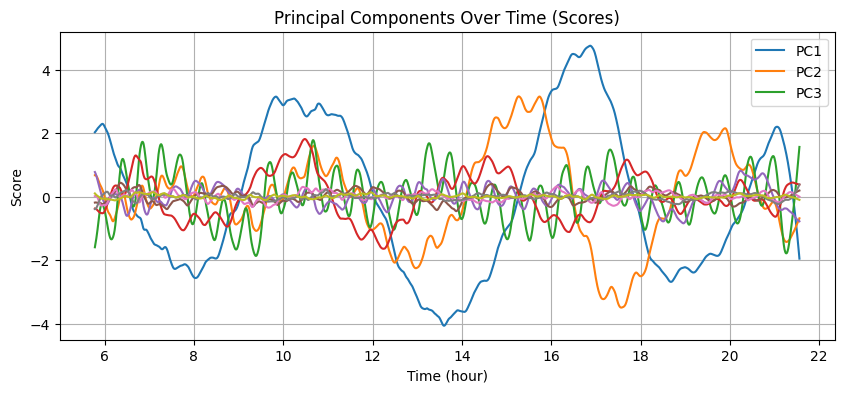

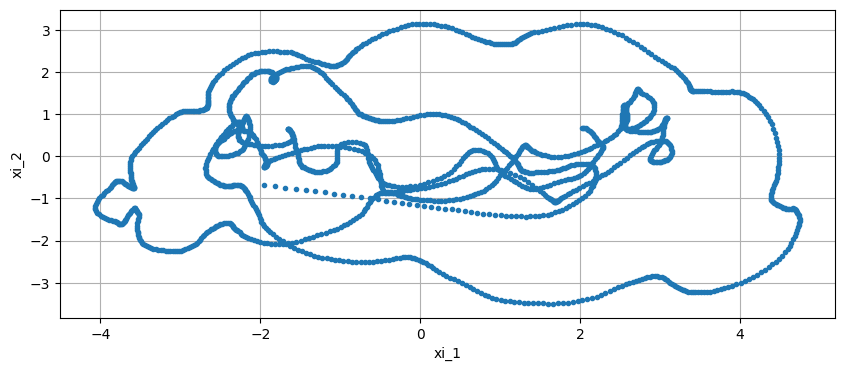

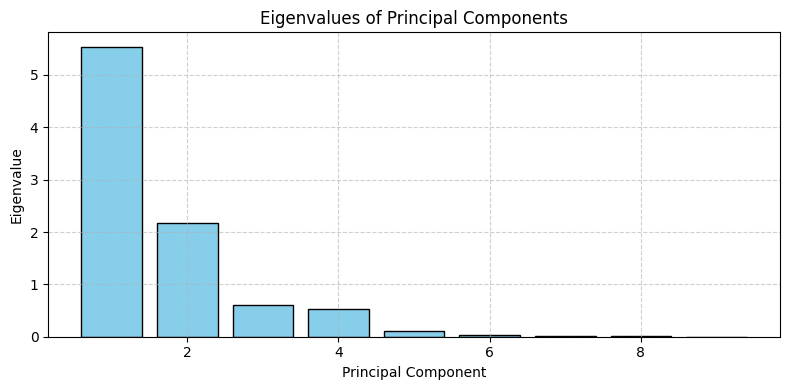

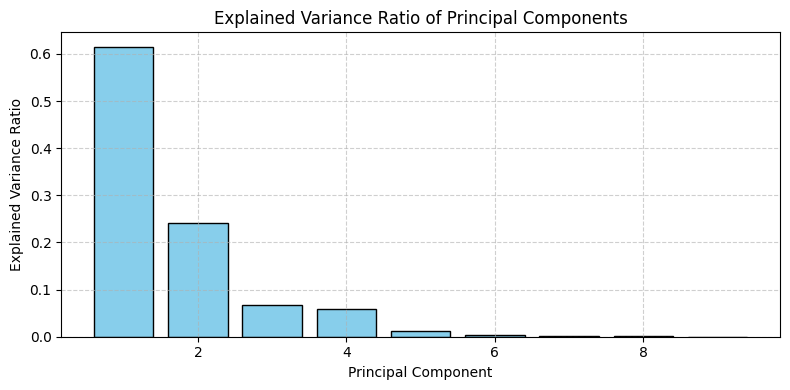

In [65]:
# Step 1: Stack and transpose
X = np.vstack([
    IB_dx, IB_dy, IB_dz,
    IT_dx, IT_dy, IT_dz,
    IL_dx, IL_dy, IL_dz,
    ]).T

print('shape(X):')
print(np.shape(X))

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA
pca = PCA(n_components=np.shape(X)[1])
X_pca = pca.fit_transform(X_scaled)
# Get the eigenvectors (principal directions)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_

# After fitting PCA

print('X_pca:')
print(X_pca)

print("Eigenvalues:")
print(eigenvalues)

print("Eigenvectors (Principal Directions):")
print(eigenvectors)

# Explained variance ratio
print("Explained Variance Ratio:")
print(explained_variance_ratio)


plt.figure(figsize=(10, 4))
plt.plot(time[active_slice], X_pca)
plt.title("Principal Components Over Time (Scores)")
plt.legend(["PC1", "PC2", "PC3"])
plt.xlabel("Time (hour)")
plt.ylabel("Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(X_pca[:,0],X_pca[:,1],'.')
plt.xlabel("xi_1")
plt.ylabel("xi_2")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, color='skyblue', edgecolor='k')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of Principal Components')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(eigenvalues) + 1), explained_variance_ratio, color='skyblue', edgecolor='k')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## with hoop

shape(X):
(1894, 15)
X_pca:
[[ 1.30936695  1.63388933 -0.01017722 ...  0.29286843 -0.21303587
   0.08403099]
 [ 1.35719521  1.60459951 -0.07354709 ...  0.29398987 -0.21714529
   0.07215787]
 [ 1.40693029  1.58091715 -0.10074972 ...  0.29257022 -0.21809632
   0.06029691]
 ...
 [-0.98945239 -1.60012909  0.06067106 ... -0.23056966  0.15570451
  -0.08185745]
 [-1.10701701 -1.61838537  0.02746878 ... -0.25546392  0.17659094
  -0.08518239]
 [-1.22644048 -1.63947982 -0.01169821 ... -0.27990399  0.19895849
  -0.08814947]]
Eigenvalues:
[7.31194054e+00 2.41533382e+00 1.62213936e+00 1.40348157e+00
 7.92096664e-01 5.29081901e-01 4.68192782e-01 2.12863891e-01
 9.43998419e-02 8.66195943e-02 3.25414944e-02 2.28282090e-02
 7.86158123e-03 6.34776388e-03 2.19491636e-03]
Eigenvectors (Principal Directions):
[[-0.1602003  -0.2401205   0.18810438  0.33076761  0.34469928 -0.33127526
   0.34341381 -0.26023038  0.31721168  0.34939909 -0.34396235 -0.08497232
   0.04959015 -0.03660054  0.07511054]
 [ 0.44243284

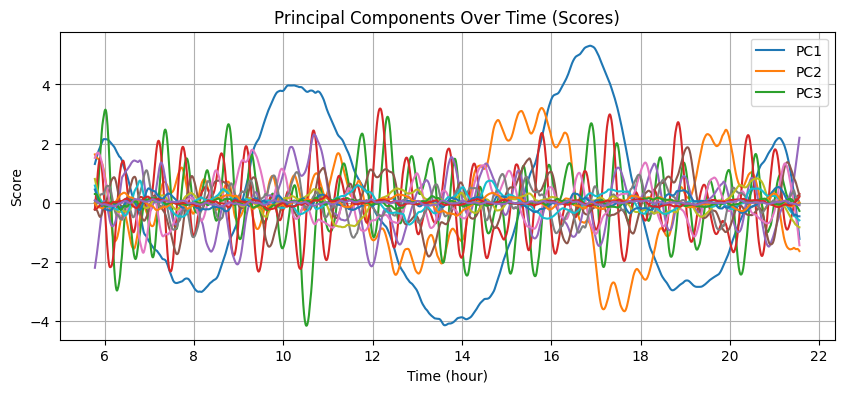

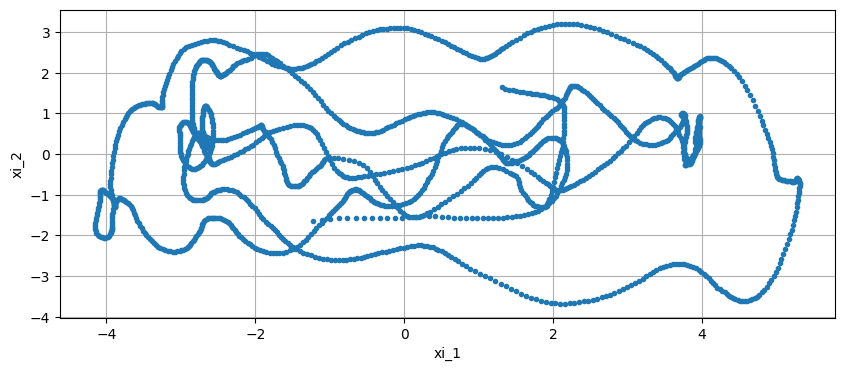

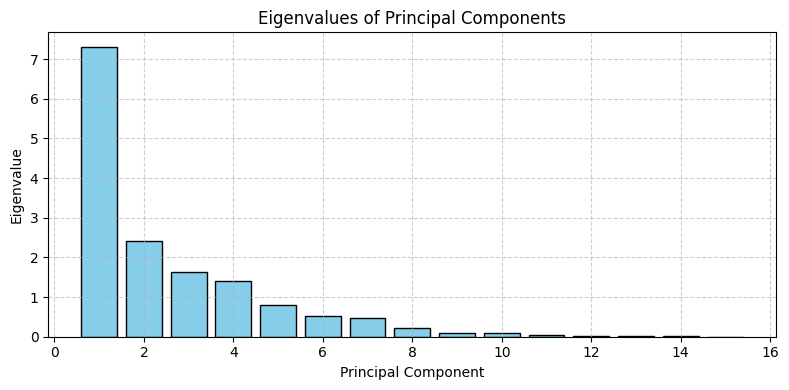

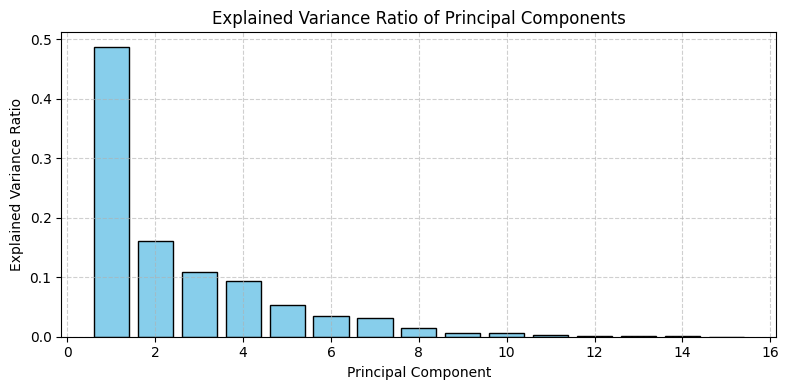

In [66]:
# Step 1: Stack and transpose
X = np.vstack([
    IB_dx, IB_dy, IB_dz,
    IT_dx, IT_dy, IT_dz,
    IL_dx, IL_dy, IL_dz,
    OL_dx, OL_dy,OL_dz,
    OR_dx, OR_dy,OR_dz,
    ]).T

print('shape(X):')
print(np.shape(X))

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA
pca = PCA(n_components=np.shape(X)[1])
X_pca = pca.fit_transform(X_scaled)
# Get the eigenvectors (principal directions)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_

# After fitting PCA

print('X_pca:')
print(X_pca)

print("Eigenvalues:")
print(eigenvalues)

print("Eigenvectors (Principal Directions):")
print(eigenvectors)

# Explained variance ratio
print("Explained Variance Ratio:")
print(explained_variance_ratio)


plt.figure(figsize=(10, 4))
plt.plot(time[active_slice], X_pca)
plt.title("Principal Components Over Time (Scores)")
plt.legend(["PC1", "PC2", "PC3"])
plt.xlabel("Time (hour)")
plt.ylabel("Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(X_pca[:,0],X_pca[:,1],'.')
plt.xlabel("xi_1")
plt.ylabel("xi_2")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, color='skyblue', edgecolor='k')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of Principal Components')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(eigenvalues) + 1), explained_variance_ratio, color='skyblue', edgecolor='k')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# To check

In [62]:
sensors = ['OR', 'OL']
quantities = ['A', 'v', 'd']
axes = ['x', 'y', 'z']
subplot_titles = [f'{q}{a}' for a in axes for q in quantities]

fig = make_subplots(
    rows=3, 
    cols=3, 
    subplot_titles=subplot_titles,
    horizontal_spacing=0.08
)

data_map = {
    'A': {'OR': {'x': OR_Ax, 'y': OR_Ay, 'z': OR_Az}, 'OL': {'x': OL_Ax, 'y': OL_Ay, 'z': OL_Az}},
    'v': {'OR': {'x': OR_vx, 'y': OR_vy, 'z': OR_vz}, 'OL': {'x': OL_vx, 'y': OL_vy, 'z': OL_vz}},
    'd': {'OR': {'x': OR_dx, 'y': OR_dy, 'z': OR_dz}, 'OL': {'x': OL_dx, 'y': OL_dy, 'z': OL_dz}}
}
time_map = {'A': time, 'v': time[1:], 'd': time[2:]}
time_cols = {'A': 1, 'v': 2, 'd': 3}
colors = {'OR': 'rgba(255, 128, 0, 0.8)', 'OL': 'rgba(0, 0, 255, 0.8)'}
legend_shown = {sensor: False for sensor in sensors}

for col, quantity in enumerate(quantities, start=1):
    for row, axis in enumerate(axes, start=1):
        for sensor in sensors:
            fig.add_trace(go.Scatter(
                x=time_map[quantity],
                y=data_map[quantity][sensor][axis],
                mode='lines',
                name=f'{sensor}',
                legendgroup=f'{sensor}',
                line=dict(color=colors[sensor], width=1),
                showlegend=not legend_shown[sensor]
            ), row=row, col=col)
        
            legend_shown[sensor] = True

fig.update_layout(
    height=600,
    width=800,
    title_text="Position of Two Points on Hoop",
)

fig.show()

In [ ]:
# 3D plot of hoop sensor displacement path

fig_hooppath = go.Figure()
fig_hooppath.add_trace(go.Scatter3d(x=OR_dx, y=OR_dy, z=OR_dz, mode='lines', name='OR'))
fig_hooppath.add_trace(go.Scatter3d(x=OL_dx, y=OL_dy, z=OL_dz, mode='lines', name='OL'))
fig_hooppath.update_layout(height=500,width=600,
    title_text="Hoop Sensor Displacement"
)
fig_hooppath.show()

: 

In [ ]:
sensors = ['IT', 'IL', 'IB']
axes = ['Ax', 'Ay', 'Az']
subplot_titles = [f'{s} {a}' for a in axes for s in sensors]

fig_ahip = make_subplots(rows=3, cols=3, subplot_titles=subplot_titles)

data_map = {
    'IT': {'Ax': IT_Ax, 'Ay': IT_Ay, 'Az': IT_Az},
    'IL': {'Ax': IL_Ax, 'Ay': IL_Ay, 'Az': IL_Az},
    'IB': {'Ax': IB_Ax, 'Ay': IB_Ay, 'Az': IB_Az},
}

for row, axis in enumerate(axes, start=1):
    for col, sensor in enumerate(sensors, start=1):
        fig_ahip.add_trace(go.Scatter(x=time, y=data_map[sensor][axis], mode='lines', showlegend=False, line=dict(color='#007bff')),
                           row=row, col=col)

fig_ahip.update_layout(height=600, width=800, title_text="Positions of Hips")

fig_ahip.show()

: 

One side of hip moves more (has more agressive bursts) than the other side. Verified by video?
Also for lower hip, most motion along Ay. See orientation of sensor to interpret.

# Hip displacement

In [ ]:
sensors = ['IT', 'IL', 'IB']
axes = ['dx', 'dy', 'dz']
subplot_titles = [f'{s} {a}' for a in axes for s in sensors]

fig_xhip = make_subplots(rows=3, cols=3, subplot_titles=subplot_titles)

data_map = {
    'IT': {'dx': IT_dx, 'dy': IT_dy, 'dz': IT_dz},
    'IL': {'dx': IL_dx, 'dy': IL_dy, 'dz': IL_dz},
    'IB': {'dx': IB_dx, 'dy': IB_dy, 'dz': IB_dz},
}

line_color = '#007bff'

for row, axis in enumerate(axes, start=1):
    for col, sensor in enumerate(sensors, start=1):
        fig_xhip.add_trace(go.Scatter(x=time[2:], y=data_map[sensor][axis], mode='lines', showlegend=False, line=dict(color=line_color)), row=row, col=col)

fig_xhip.update_layout(height=600, width=800, title_text="Positions of Hips")

fig_xhip.show()

: 

So interesting the jitters along dz for the upper hip and in all directions for lower hip. Maybe upper hip dz are needed to sustain hoop and lower hip jitters enables the upper hip to create these jitters. No jitters in upper hip in the horizontal plane. Look at human body anatomy to verify this.

Is it possible that the hip is displacing 20 cm along the vertical. Or is this vertical displacement an artifact of errors.

# Animating hoop motion

In [ ]:
from utilities_hula_hoop import extract_rotation
from scipy.spatial.transform import Rotation
import meshio
import veux
import veux.motion

speed = 1/2 # animation will be shown at this fraction of the true speed

psi   = np.vstack((OL_psi,   OR_psi)) 
theta = np.vstack((OL_theta, OR_theta)) 
phi   = np.vstack((OL_phi,   OR_phi)) 

wx = np.vstack((OL_wx, OR_wx))
wy = np.vstack((OL_wy, OR_wy))
wz = np.vstack((OL_wz, OR_wz))

dx = np.vstack((np.concatenate(([0, 0], OL_dx)), 
                np.concatenate(([0, 0], OR_dx))))
dy = np.vstack((np.concatenate(([0, 0], OL_dy)), 
                np.concatenate(([0, 0], OR_dy)))) 
dz = np.vstack((np.concatenate(([0, 0], OL_dz)), 
                np.concatenate(([0, 0], OR_dz)))) 

xs = np.array((
    (OL_dx, OL_dy, OL_dz),
    (OR_dx, OR_dy, OR_dz)
))

nsensor = np.shape(psi)[0]
ntime   = np.shape(psi)[1]

model = {
    "nodes": [[0,0,0] for _ in range(nsensor)]
}

# 2) Create an artist to manage the canvas
artist = veux.create_artist(model, vertical=3, model_config={
    "node_marker": meshio.read("hoop.stl"),
    "node_marker_scale": 1/100, # Hoop drawing is in cm
})

artist.draw_origin(scale=1/10, extrude=True)

# 3) Create a motion to manage the animation
motion = veux.motion.Motion(artist)

# Build the animation

exOL_0, eyOL_0, ezOL_0 = extract_rotation(phi[0,0], theta[0,0], psi[0,0],np.array([np.cos(2.46),np.sin(2.46),0]),np.array([-np.sin(2.46),np.cos(2.46),0]))
exOR_0, eyOR_0, ezOR_0 = extract_rotation(phi[1,0], theta[1,0], psi[1,0])

XOR = 0
XOL = r*(eyOR_0-eyOL_0)

for t in range(ntime):
    x = {}
    R = {}
    # Compute the position and rotation of each sensor at time t
    for s in range(nsensor):
        if s == 0:
            ex, ey, ez = extract_rotation(phi[s,t], theta[s,t], psi[s,t])
        if s == 1:
            ex, ey, ez = extract_rotation(phi[s,t], theta[s,t], psi[s,t],np.array([np.cos(2.46),np.sin(2.46),0]),np.array([-np.sin(2.46),np.cos(2.46),0]))

        # a) setup rotation 
        # Either of these two lines works:
        # R[s] = Rotation.from_matrix(np.vstack((ex, ey, ez)).T)
        R[s] = Rotation.from_euler('xyz', [phi[s,t], theta[s,t], psi[s,t]], degrees=False)

        # b) setup position 
        if s == 0:
            x[s] = XOL + np.array([dx[0,t],dy[0,t],dz[0,t]]) + r*ey
        if s == 1:
            x[s] = x[0]


    # Draw a frame
    motion.draw_nodes(position = lambda s: x[s].flatten(),
                      rotation = lambda s: R[s].as_quat().tolist()
    )

    # plot at a fraction of the true speed
    motion.advance(time[t]*1/speed)

# Add the motion to the artist's canvas
motion.add_to(artist.canvas)

# Free online viewer for .glb files: https://gltf-viewer.donmccurdy.com/
artist.save("hula.glb")
artist

: 

In [ ]:
# Plotting hoop seperately from two sensor data on same plot
# %matplotlib widget

colors = ['k','b','r','g']
r_arr = [r,r,0.12,0.12]

# Set up figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=35)
ax.set_box_aspect([4, 4, 3])  # Adjust for box on

max_range = 1
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range, max_range])

# Fixed basis vectors
ax.quiver(0, 0, 0, 0.01, 0, 0, linewidth=2, color='k')
ax.quiver(0, 0, 0, 0, 0.01, 0, linewidth=2, color='k')
ax.quiver(0, 0, 0, 0, 0, 0.01, linewidth=2, color='k')

delta = np.linspace(0, 2 * np.pi, 100)
xC = np.zeros(3)  # center of hoop

psi = np.vstack((OL_psi,OR_psi,IT_psi,IL_psi)) 
theta = np.vstack((OL_theta,OR_theta,IT_theta,IL_theta)) 
phi = np.vstack((OL_phi,OR_phi,IT_phi,IL_phi)) 

wx = np.vstack((OL_wx, OR_wx,IT_wx,IL_wx)) 
wy = np.vstack((OL_wy, OR_wy,IT_wy,IL_wy)) 
wz = np.vstack((OL_wz, OR_wz,IT_wz,IL_wz)) 

OR_dx_padded = np.concatenate(([0, 0], OR_dx))
OR_dy_padded = np.concatenate(([0, 0], OR_dy))
OR_dz_padded = np.concatenate(([0, 0], OR_dz))
        
OR_vx_padded = np.concatenate(([0], OR_vx))
OR_vy_padded = np.concatenate(([0], OR_vy))
OR_vz_padded = np.concatenate(([0], OR_vz))

OL_dx_padded = np.concatenate(([0, 0], OL_dx))
OL_dy_padded = np.concatenate(([0, 0], OL_dy))
OL_dz_padded = np.concatenate(([0, 0], OL_dz))
        
OL_vx_padded = np.concatenate(([0], OL_vx))
OL_vy_padded = np.concatenate(([0], OL_vy))
OL_vz_padded = np.concatenate(([0], OL_vz))

IT_dx_padded = np.concatenate(([0, 0], IT_dx))
IT_dy_padded = np.concatenate(([0, 0], IT_dy))
IT_dz_padded = np.concatenate(([0, 0], IT_dz))
        
IT_vx_padded = np.concatenate(([0], IT_vx))
IT_vy_padded = np.concatenate(([0], IT_vy))
IT_vz_padded = np.concatenate(([0], IT_vz))

IB_dx_padded = np.concatenate(([0, 0], IB_dx))
IB_dy_padded = np.concatenate(([0, 0], IB_dy))
IB_dz_padded = np.concatenate(([0, 0], IB_dz))
        
IB_vx_padded = np.concatenate(([0], IB_vx))
IB_vy_padded = np.concatenate(([0], IB_vy))
IB_vz_padded = np.concatenate(([0], IB_vz))

dx = np.vstack((OL_dx_padded, OR_dx_padded, IT_dx_padded, IB_dx_padded)) 
dy = np.vstack((OL_dy_padded, OR_dy_padded, IT_dy_padded, IB_dy_padded)) 
dz = np.vstack((OL_dz_padded, OR_dz_padded, IT_dz_padded, IB_dz_padded)) 

vx = np.vstack((OL_vx_padded, OR_vx_padded, IT_vx_padded, IB_vx_padded)) 
vy = np.vstack((OL_vy_padded, OR_vy_padded, IT_vy_padded, IB_vy_padded)) 
vz = np.vstack((OL_vz_padded, OR_vz_padded, IT_vz_padded, IB_vz_padded))

nsensor = np.shape(psi)[0]
ntime = np.shape(psi)[1]

KE_hoop = np.zeros((nsensor,ntime))
PE_hoop = np.zeros((nsensor,ntime))

exp = np.zeros((3,nsensor,ntime))
eyp = np.zeros((3,nsensor,ntime))
ezp = np.zeros((3,nsensor,ntime))

expp = np.zeros((3,nsensor,ntime))
eypp = np.zeros((3,nsensor,ntime))
ezpp = np.zeros((3,nsensor,ntime))

ex = np.zeros((3,nsensor,ntime))
ey = np.zeros((3,nsensor,ntime))
ez = np.zeros((3,nsensor,ntime))

omega_hoop = np.zeros((3,nsensor,ntime))
vC = np.zeros((3,nsensor,ntime))

mark = [None] * nsensor
hoop = [None] * nsensor

# Prepare video writer
writer = FFMpegWriter(fps=round(1/dt)//3)
with writer.saving(fig, "out/hula_hoop_two_sensors.mp4", dpi=200):

    for t in range(2000,2500):

        for s in range(nsensor):
            # s == 0, sensor OL
            # s == 1, sensor OR

            # First rotation by an angle psi about E3
            exp[:,s,t] = np.cos(psi[s,t])*E1+np.sin(psi[s,t])*E2
            eyp[:,s,t] = -np.sin(psi[s,t])*E1+np.cos(psi[s,t])*E2
            ezp[:,s,t] = E3
            # Second rotation by an angle theta about e2p
            expp[:,s,t] = np.cos(theta[s,t])*exp[:,s,t]-np.sin(theta[s,t])*ezp[:,s,t]
            eypp[:,s,t] = eyp[:,s,t]
            ezpp[:,s,t] = np.sin(theta[s,t])*exp[:,s,t]+np.cos(theta[s,t])*ezp[:,s,t]
            # Third rotation by an angle phi about e1pp
            ex[:,s,t] = expp[:,s,t]
            ey[:,s,t] = np.cos(phi[s,t])*eypp[:,s,t]+np.sin(phi[s,t])*ezpp[:,s,t]
            ez[:,s,t] = -np.sin(phi[s,t])*eypp[:,s,t]+np.cos(phi[s,t])*ezpp[:,s,t]

            omega_hoop[:,s,t] = wx[s,t]*ex[:,s,t]+wy[s,t]*ey[:,s,t]+wz[s,t]*ez[:,s,t]

            vC[:,s,t] = np.array([vx[s,t],vy[s,t],vz[s,t]])+np.cross(omega_hoop[:,s,t],r_arr[s]*ey[:,s,t])

            KE_hoop[s,t] = 0.5*(Ixx*wx[s,t]**2+Iyy*wy[s,t]**2+Izz*wz[s,t]**2)+0.5*nsensor*np.linalg.norm(vC[:,s,t])**2
            PE_hoop[s,t] = m*g*dz[s,t]

            ax.set_title(f"sensor = {s}, t = {t}, ψ = {psi[s,t]:.2f}, θ = {theta[s,t]:.2f}, φ = {phi[s,t]:.2f}")

            # Blue vectors
            e1p_plot = ax.quiver(0, 0, 0, *0.01*exp[:,s,t], linewidth=1, color='b')
            e2p_plot = ax.quiver(0, 0, 0, *0.01*eyp[:,s,t], linewidth=1, color='b')
            e3p_plot = ax.quiver(0, 0, 0, *0.01*ezp[:,s,t], linewidth=1, color='b')
            
            # Red vectors
            e1pp_plot = ax.quiver(0, 0, 0, *0.01*expp[:,s,t], linewidth=1, color='r')
            e2pp_plot = ax.quiver(0, 0, 0, *0.01*eypp[:,s,t], linewidth=1, color='r')
            e3pp_plot = ax.quiver(0, 0, 0, *0.01*ezpp[:,s,t], linewidth=1, color='r')

            # Green vectors
            e1_plot = ax.quiver(0, 0, 0, *0.01*ex[:,s,t], linewidth=1, color='g')
            e2_plot = ax.quiver(0, 0, 0, *0.01*ey[:,s,t], linewidth=1, color='g')
            e3_plot = ax.quiver(0, 0, 0, *0.01*ez[:,s,t], linewidth=1, color='g')

            # OR_0 = np.array([0,0,0])
            # OL_0 = OR_0+r_arr[s]*(ey[:,1,0]-ey[:,0,0])
            # IT_0 = OR_0
            # IL_0 = IT_0-2*r_arr[s]*ez[:,0,0]

            # if s == 0:  # OL
            #     xC = OL_0+np.array([dx[s,t],dy[s,t],dz[s,t]])+r_arr[s]*ey[:,s,t]
            # if s == 1:  # OR
            #     xC = OR_0+np.array([dx[s,t],dy[s,t],dz[s,t]])+r_arr[s]*ey[:,s,t]
            # if s == 2:  # IT
            #     xC = IT_0+np.array([dx[s,t],dy[s,t],dz[s,t]])-r_arr[s]*ez[:,s,t]
            # if s == 3:  # IL
            #     xC = IL_0+np.array([dx[s,t],dy[s,t],dz[s,t]])-r_arr[s]*ez[:,s,t]


            if s == 0:  # OL
                xC = np.array([dx[s,t],dy[s,t],dz[s,t]])+r_arr[s]*ey[:,0,t]
            if s == 1:  # OR
                xC = np.array([dx[s,t],dy[s,t],dz[s,t]])+r_arr[s]*ey[:,0,t]
            if s == 2:  # IT
                xC = np.array([dx[s,t],dy[s,t],dz[s,t]])-r_arr[s]*ez[:,0,t]
            if s == 3:  # IL
                xC = np.array([dx[s,t],dy[s,t],dz[s,t]])-r_arr[s]*ez[:,0,t]

            
            # Circle
            xCircle = np.zeros((100, 3))
            if s == 0 or s == 1:
                for j in range(100):
                    xCircle[j, :] = xC + r_arr[s] * (np.cos(delta[j]) * ex[:,s,t] + np.sin(delta[j]) * ey[:,s,t])
            if s == 2 or s == 3:
                for j in range(100):
                    xCircle[j, :] = xC + r_arr[s] * (np.cos(delta[j]) * ey[:,s,t] + np.sin(delta[j]) * ez[:,s,t])

            mark[s], = ax.plot([xCircle[0, 0]], [xCircle[0, 1]], [xCircle[0, 2]],
                            marker='*', color='r', linewidth=2)
            hoop[s], = ax.plot(xCircle[:, 0], xCircle[:, 1], xCircle[:, 2],
                            '.', color=colors[s], linewidth=2)

        # plt.pause(0.001)
        writer.grab_frame()

        # Remove current frame's artists
        for s in range(nsensor):
            mark[s].remove()
            hoop[s].remove()
        for artist in [e1p_plot, e2p_plot, e3p_plot,
                    e1pp_plot, e2pp_plot, e3pp_plot,
                    e1_plot, e2_plot, e3_plot]:
            artist.remove()

# total energy of hoop
E_hoop = KE_hoop+PE_hoop


: 

In [26]:
# Plotting hoop seperately from two sensor data on same plot
# %matplotlib widget

colors = ['k','b','r','g']
r_arr = [r,r,0.12,0.12]

# # Set up figure and 3D axes
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.view_init(elev=20, azim=35)
# ax.set_box_aspect([4, 4, 3])  # Adjust for box on

# max_range = 1
# ax.set_xlim([-max_range, max_range])
# ax.set_ylim([-max_range, max_range])
# ax.set_zlim([-max_range, max_range])

# # Fixed basis vectors
# ax.quiver(0, 0, 0, 0.01, 0, 0, linewidth=2, color='k')
# ax.quiver(0, 0, 0, 0, 0.01, 0, linewidth=2, color='k')
# ax.quiver(0, 0, 0, 0, 0, 0.01, linewidth=2, color='k')

delta = np.linspace(0, 2 * np.pi, 100)
xC = np.zeros(3)  # center of hoop

psi = np.vstack((OL_psi,OR_psi,IT_psi,IL_psi)) 
theta = np.vstack((OL_theta,OR_theta,IT_theta,IL_theta)) 
phi = np.vstack((OL_phi,OR_phi,IT_phi,IL_phi)) 

wx = np.vstack((OL_wx, OR_wx,IT_wx,IL_wx)) 
wy = np.vstack((OL_wy, OR_wy,IT_wy,IL_wy)) 
wz = np.vstack((OL_wz, OR_wz,IT_wz,IL_wz)) 

OR_dx_padded = np.concatenate(([0, 0], OR_dx))
OR_dy_padded = np.concatenate(([0, 0], OR_dy))
OR_dz_padded = np.concatenate(([0, 0], OR_dz))
        
OR_vx_padded = np.concatenate(([0], OR_vx))
OR_vy_padded = np.concatenate(([0], OR_vy))
OR_vz_padded = np.concatenate(([0], OR_vz))

OL_dx_padded = np.concatenate(([0, 0], OL_dx))
OL_dy_padded = np.concatenate(([0, 0], OL_dy))
OL_dz_padded = np.concatenate(([0, 0], OL_dz))
        
OL_vx_padded = np.concatenate(([0], OL_vx))
OL_vy_padded = np.concatenate(([0], OL_vy))
OL_vz_padded = np.concatenate(([0], OL_vz))

IT_dx_padded = np.concatenate(([0, 0], IT_dx))
IT_dy_padded = np.concatenate(([0, 0], IT_dy))
IT_dz_padded = np.concatenate(([0, 0], IT_dz))
        
IT_vx_padded = np.concatenate(([0], IT_vx))
IT_vy_padded = np.concatenate(([0], IT_vy))
IT_vz_padded = np.concatenate(([0], IT_vz))

IB_dx_padded = np.concatenate(([0, 0], IB_dx))
IB_dy_padded = np.concatenate(([0, 0], IB_dy))
IB_dz_padded = np.concatenate(([0, 0], IB_dz))
        
IB_vx_padded = np.concatenate(([0], IB_vx))
IB_vy_padded = np.concatenate(([0], IB_vy))
IB_vz_padded = np.concatenate(([0], IB_vz))

dx = np.vstack((OL_dx_padded, OR_dx_padded, IT_dx_padded, IB_dx_padded)) 
dy = np.vstack((OL_dy_padded, OR_dy_padded, IT_dy_padded, IB_dy_padded)) 
dz = np.vstack((OL_dz_padded, OR_dz_padded, IT_dz_padded, IB_dz_padded)) 

vx = np.vstack((OL_vx_padded, OR_vx_padded, IT_vx_padded, IB_vx_padded)) 
vy = np.vstack((OL_vy_padded, OR_vy_padded, IT_vy_padded, IB_vy_padded)) 
vz = np.vstack((OL_vz_padded, OR_vz_padded, IT_vz_padded, IB_vz_padded))

nsensor = np.shape(psi)[0]
ntime = np.shape(psi)[1]

KE_hoop = np.zeros((nsensor,ntime))
PE_hoop = np.zeros((nsensor,ntime))

exp = np.zeros((3,nsensor,ntime))
eyp = np.zeros((3,nsensor,ntime))
ezp = np.zeros((3,nsensor,ntime))

expp = np.zeros((3,nsensor,ntime))
eypp = np.zeros((3,nsensor,ntime))
ezpp = np.zeros((3,nsensor,ntime))

ex = np.zeros((3,nsensor,ntime))
ey = np.zeros((3,nsensor,ntime))
ez = np.zeros((3,nsensor,ntime))

omega_hoop = np.zeros((3,nsensor,ntime))
vC = np.zeros((3,nsensor,ntime))

mark = [None] * nsensor
hoop = [None] * nsensor

# Prepare video writer
# writer = FFMpegWriter(fps=round(1/dt)//3)
# with writer.saving(fig, "out/hula_hoop_two_sensors.mp4", dpi=200):

E1,E2,E3 = np.eye(3)

for t in range(ntime):

    for s in range(nsensor):
        # s == 0, sensor OL
        # s == 1, sensor OR

        # First rotation by an angle psi about E3
        exp[:,s,t] = np.cos(psi[s,t])*E1+np.sin(psi[s,t])*E2
        eyp[:,s,t] = -np.sin(psi[s,t])*E1+np.cos(psi[s,t])*E2
        ezp[:,s,t] = E3
        # Second rotation by an angle theta about e2p
        expp[:,s,t] = np.cos(theta[s,t])*exp[:,s,t]-np.sin(theta[s,t])*ezp[:,s,t]
        eypp[:,s,t] = eyp[:,s,t]
        ezpp[:,s,t] = np.sin(theta[s,t])*exp[:,s,t]+np.cos(theta[s,t])*ezp[:,s,t]
        # Third rotation by an angle phi about e1pp
        ex[:,s,t] = expp[:,s,t]
        ey[:,s,t] = np.cos(phi[s,t])*eypp[:,s,t]+np.sin(phi[s,t])*ezpp[:,s,t]
        ez[:,s,t] = -np.sin(phi[s,t])*eypp[:,s,t]+np.cos(phi[s,t])*ezpp[:,s,t]

        omega_hoop[:,s,t] = wx[s,t]*ex[:,s,t]+wy[s,t]*ey[:,s,t]+wz[s,t]*ez[:,s,t]

        vC[:,s,t] = np.array([vx[s,t],vy[s,t],vz[s,t]])+np.cross(omega_hoop[:,s,t],r_arr[s]*ey[:,s,t])

        KE_hoop[s,t] = 0.5*(Ixx*wx[s,t]**2+Iyy*wy[s,t]**2+Izz*wz[s,t]**2)+0.5*nsensor*np.linalg.norm(vC[:,s,t])**2
        PE_hoop[s,t] = m*g*dz[s,t]

        # ax.set_title(f"sensor = {s}, t = {t}, ψ = {psi[s,t]:.2f}, θ = {theta[s,t]:.2f}, φ = {phi[s,t]:.2f}")

        # # Blue vectors
        # e1p_plot = ax.quiver(0, 0, 0, *0.01*exp[:,s,t], linewidth=1, color='b')
        # e2p_plot = ax.quiver(0, 0, 0, *0.01*eyp[:,s,t], linewidth=1, color='b')
        # e3p_plot = ax.quiver(0, 0, 0, *0.01*ezp[:,s,t], linewidth=1, color='b')
        
        # # Red vectors
        # e1pp_plot = ax.quiver(0, 0, 0, *0.01*expp[:,s,t], linewidth=1, color='r')
        # e2pp_plot = ax.quiver(0, 0, 0, *0.01*eypp[:,s,t], linewidth=1, color='r')
        # e3pp_plot = ax.quiver(0, 0, 0, *0.01*ezpp[:,s,t], linewidth=1, color='r')

        # # Green vectors
        # e1_plot = ax.quiver(0, 0, 0, *0.01*ex[:,s,t], linewidth=1, color='g')
        # e2_plot = ax.quiver(0, 0, 0, *0.01*ey[:,s,t], linewidth=1, color='g')
        # e3_plot = ax.quiver(0, 0, 0, *0.01*ez[:,s,t], linewidth=1, color='g')

        # OR_0 = np.array([0,0,0])
        # OL_0 = OR_0+r_arr[s]*(ey[:,1,0]-ey[:,0,0])
        # IT_0 = OR_0
        # IL_0 = IT_0-2*r_arr[s]*ez[:,0,0]

        # if s == 0:  # OL
        #     xC = OL_0+np.array([dx[s,t],dy[s,t],dz[s,t]])+r_arr[s]*ey[:,s,t]
        # if s == 1:  # OR
        #     xC = OR_0+np.array([dx[s,t],dy[s,t],dz[s,t]])+r_arr[s]*ey[:,s,t]
        # if s == 2:  # IT
        #     xC = IT_0+np.array([dx[s,t],dy[s,t],dz[s,t]])-r_arr[s]*ez[:,s,t]
        # if s == 3:  # IL
        #     xC = IL_0+np.array([dx[s,t],dy[s,t],dz[s,t]])-r_arr[s]*ez[:,s,t]

        
        # # Circle
        # xCircle = np.zeros((100, 3))
        # if s == 0 or s == 1:
        #     for j in range(100):
        #         xCircle[j, :] = xC + r_arr[s] * (np.cos(delta[j]) * ex[:,s,t] + np.sin(delta[j]) * ey[:,s,t])
        # if s == 2 or s == 3:
        #     for j in range(100):
        #         xCircle[j, :] = xC + r_arr[s] * (np.cos(delta[j]) * ey[:,s,t] + np.sin(delta[j]) * ez[:,s,t])

        # mark[s], = ax.plot([xCircle[0, 0]], [xCircle[0, 1]], [xCircle[0, 2]],
        #                 marker='*', color='r', linewidth=2)
        # hoop[s], = ax.plot(xCircle[:, 0], xCircle[:, 1], xCircle[:, 2],
        #                 '.', color=colors[s], linewidth=2)

    # # plt.pause(0.001)
    # writer.grab_frame()
    #
    # # Remove current frame's artists
    # for s in range(nsensor):
    #     mark[s].remove()
    #     hoop[s].remove()
    # for artist in [e1p_plot, e2p_plot, e3p_plot,
    #             e1pp_plot, e2pp_plot, e3pp_plot,
    #             e1_plot, e2_plot, e3_plot]:
    #     artist.remove()

# total energy of hoop
E_hoop = KE_hoop+PE_hoop


: 

# Measures of Rigidity

In [ ]:
%matplotlib widget

ntime = np.shape(psi)[1]

angle = np.zeros(ntime)
for t in range(ntime):
    angle[t] = np.arccos(np.dot(ey[:,0,t],ey[:,1,t]))

fig_a, ax_a = plt.subplots(figsize=(6, 8))
ax_a.plot(180-angle*180/np.pi)



: 

The angle between the two corotational ey vectors of the two sensors on the hoop should remain constant. This 40degrees angle change is too much. Is one of the sensors moving?

In [ ]:
# Comparing data from the two sensors
# Measures of rigidity

# Angular velocities
fig_w, ax_w = plt.subplots(3,1,figsize=(6, 8))
for s in range(nsensor):
    for i in range(3):
        ax_w[i].plot(omega_hoop[i,s,:],label=f'sensor {s}, w{i}') 
        ax_w[i].legend()

# Unit vector ez
fig_ez, ax_ez = plt.subplots(3,1,figsize=(6, 8))
for s in range(nsensor):
    for i in range(3):
        ax_ez[i].plot(ez[i,s,:],label=f'sensor {s}, ez{i}') 
        ax_ez[i].legend()

# Calculating the relative position vector between the two sensors
# https://chatgpt.com/share/687ff75c-b810-8011-bd51-12152ce2bfab

fig_r, ax_r = plt.subplots(4,1,figsize=(6, 8))

r_OL_wrt_OR = np.zeros((3,nsensor,ntime))
norm_r_OL_wrt_OR = np.zeros((nsensor,ntime))

for t in range(ntime-1):
    temp1 = np.array([OL_vx[t], OL_vy[t], OL_vz[t]])-np.array([OR_vx[t], OR_vy[t], OR_vz[t]])
    for s in range(nsensor):
        temp2 = np.cross(omega_hoop[:,s,t],temp1)/(np.linalg.norm(temp1)**2)
        k = -np.dot(temp2,ez[:,s,t])/(np.dot(temp1,ez[:,s,t]))
        r_OL_wrt_OR[:,s,t] = temp2+k*temp1
        norm_r_OL_wrt_OR[s,t] = np.linalg.norm(r_OL_wrt_OR[:,s,t])

for s in range(nsensor):
    for i in range(3):
        ax_r[i].plot(r_OL_wrt_OR[i,s,:],label=f'sensor {s}, r_OL_wrt_OR{i}') 
        ax_r[i].legend()
        ax_r[i].set_ylim([-10, 10]) 
    ax_r[3].plot(norm_r_OL_wrt_OR[s,:],label=f'sensor {s}, norm(r_OL_wrt_OR)') 
    ax_r[3].set_ylim([-10, 10]) 




: 

# Energy

In [ ]:
np.shape(E_hoop)

: 

In [ ]:
# Plot Energies
fig_E, ax_E = plt.subplots()

sensor  = 0

ax_E.plot(KE_hoop[sensor,active_slice]-np.mean(KE_hoop[sensor,active_slice]), label='KE-hoop')
# ax_E.plot(PE_hoop[sensor,:], label='PE-hoop')
# ax_E.plot(E_hoop[sensor,:], label='E-hoop')

sensor  = 1
# ax_E.plot(KE_hoop[sensor,:], label='KE-hoop')
# ax_E.plot(PE_hoop[sensor,:], label='PE-hoop')
# ax_E.plot(E_hoop[sensor,:], label='E-hoop')

ax_E.plot(IT_Az[active_slice], label='Az-hip')

ax_E.legend()


: 

Do these two signals have the same frequency?

## Smoothing Signal

In [ ]:
IT_Az_filtered = lowpass_filter(IT_Az[active_slice],5,plot=True)
KE_hoop_filtered = lowpass_filter(KE_hoop[0,active_slice]-np.mean(KE_hoop[0,active_slice]),5,plot=True)

fig, ax = plt.subplots()
ax.plot(IT_Az_filtered)
ax.plot(KE_hoop_filtered)

: 

## Finding signal period

In [ ]:
Az_period_time = estimate_period(IT_Az[active_slice], method='autocorr', plot=True)
Az_filtered_period_time = estimate_period(IT_Az_filtered, method='autocorr', plot=True)
KE_period_time = estimate_period(KE_hoop[0,active_slice], method='autocorr', plot=True)

print(f"{Az_period_time=}")
print(f"{Az_filtered_period_time=}")
print(f"{KE_period_time=}")

: 

In [ ]:
period_fft = estimate_period(IT_Az[active_slice], method='fft', plot=True)
period_psd = estimate_period(IT_Az[active_slice], method='psd', plot=True)
period_srim = estimate_period(IT_Az[active_slice], method='srim', plot=True)
print(f"{period_fft=}")
print(f"{period_psd=}")
print(f"{period_srim=}")


: 

# Outputting a .bvh file for blender

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R

# ==== FILES ====
files = {
    "OR": "IB_20250903_203926.csv",  # Hoop
    "OL": "OL_20250903_203926.csv",  # Waist (not a joint)
    "IB": "IB_20250903_203926.csv",  # Femur (not a joint)
    "IT": "IT_20250903_203926.csv",  # Tibia (not a joint)
    "IL": "IL_20250903_203926.csv",  # Cuneiform (not a joint)
}

# ==== SENSOR AND JOINT HEIGHTS (cm) ====
heights = {
    "sensors": {
        "OL": 102,   # Hoop
        "OR": 96,    # Waist (not a joint)
        "IB": 63,    # Femur (not a joint)
        "IT": 26,    # Tibia (not a joint)
        "IL": 5      # Cuneiform (not a joint)
    },
    "joints": {
        "hip": 80,
        "knee": 42,
        "ankle": 7
    }
}

# ==== LOAD AND MERGE CSVs ====
dfs = {}
for key, fname in files.items():
    df = pd.read_csv(fname)
    df = df[['SampleTimeFine', 'Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']]
    df.columns = ['time', f'{key}_w', f'{key}_x', f'{key}_y', f'{key}_z']
    dfs[key] = df

# Merge all by time
merged = dfs['OL']
for key in ['IB', 'IT', 'IL']:
    merged = pd.merge(merged, dfs[key], on='time')

# ==== CONVERT TO ROTATIONS ====
def quat_to_rot(w, x, y, z):
    """Convert (w, x, y, z) to scipy Rotation object."""
    return R.from_quat([x, y, z, w])  # SciPy expects (x, y, z, w)

OL_q = quat_to_rot(merged['OL_w'], merged['OL_x'], merged['OL_y'], merged['OL_z'])
IT_q = quat_to_rot(merged['IT_w'], merged['IT_x'], merged['IT_y'], merged['IT_z'])
IL_q = quat_to_rot(merged['IL_w'], merged['IL_x'], merged['IL_y'], merged['IL_z'])

# ==== RELATIVE ROTATIONS ====
thigh_rot = OL_q
knee_rot = OL_q.inv() * IT_q
ankle_rot = IT_q.inv() * IL_q

# ==== BVH HEADER ====
dt = 1.0 / 120.0
frames = len(merged)

header = f"""HIERARCHY
ROOT Thigh
{{
    OFFSET 0 0 0
    CHANNELS 6 Xposition Yposition Zposition Zrotation Xrotation Yrotation
    JOINT Shank
    {{
        OFFSET 0 -40 0
        CHANNELS 3 Zrotation Xrotation Yrotation
        JOINT Foot
        {{
            OFFSET 0 -40 0
            CHANNELS 3 Zrotation Xrotation Yrotation
            End Site
            {{
                OFFSET 0 -20 0
            }}
        }}
    }}
}}
MOTION
Frames: {frames}
Frame Time: {dt:.6f}
"""

# ==== MOTION DATA ====
motion_lines = []
for i in range(frames):
    root_pos = [0, 0, 0]  # No translation in this example
    r_thigh = thigh_rot[i].as_euler('ZYX', degrees=True)
    r_knee = knee_rot[i].as_euler('ZYX', degrees=True)
    r_ankle = ankle_rot[i].as_euler('ZYX', degrees=True)

    line = (
        f"{root_pos[0]:.6f} {root_pos[1]:.6f} {root_pos[2]:.6f} "
        f"{r_thigh[0]:.6f} {r_thigh[1]:.6f} {r_thigh[2]:.6f} "
        f"{r_knee[0]:.6f} {r_knee[1]:.6f} {r_knee[2]:.6f} "
        f"{r_ankle[0]:.6f} {r_ankle[1]:.6f} {r_ankle[2]:.6f}"
    )
    motion_lines.append(line)

# ==== SAVE BVH ====
with open("leg_motion.bvh", "w") as f:
    f.write(header)
    for line in motion_lines:
        f.write(line + "\n")

print("BVH file saved as leg_motion.bvh")


: 

# Inter-Joint Hilbert relative phase

In [68]:
from scipy.signal import hilbert
from itertools import combinations

In [70]:
data_omega_dict = {
    'OR': {'wx': OR_wx, 'wy': OR_wy, 'wz': OR_wz}, 
    'OL': {'wx': OL_wx, 'wy': OL_wy, 'wz': OL_wz}, 
    'IT': {'wx': IT_wx, 'wy': IT_wy, 'wz': IT_wz}, 
    'IL': {'wx': IL_wx, 'wy': IL_wy, 'wz': IL_wz}, 
    'IB': {'wx': IB_wx, 'wy': IB_wy, 'wz': IB_wz}, 
} 

data_displacement_dict = {
    'OR': {'dx': OR_dx, 'dy': OR_dy, 'dz': OR_dz}, 
    'OL': {'dx': OL_dx, 'dy': OL_dy, 'dz': OL_dz}, 
    'IT': {'dx': IT_dx, 'dy': IT_dy, 'dz': IT_dz}, 
    'IL': {'dx': IL_dx, 'dy': IL_dy, 'dz': IL_dz}, 
    'IB': {'dx': IB_dx, 'dy': IB_dy, 'dz': IB_dz}, 
} 



# Initialize dictionary to store relative phases for each component
relative_phase = {comp: {s1: {} for s1 in data_displacement_dict} for comp in ['dx','dy','dz']}

# Loop over components
for comp in ['dx', 'dy', 'dz']:
    # Loop over all unique sensor pairs
    for s1, s2 in combinations(data_displacement_dict.keys(), 2):
        # Get signals
        sig1 = data_displacement_dict[s1][comp]
        sig2 = data_displacement_dict[s2][comp]
        
        # Compute analytic signals
        analytic1 = hilbert(sig1)
        analytic2 = hilbert(sig2)
        
        # Compute instantaneous phases
        phase1 = np.angle(analytic1)
        phase2 = np.angle(analytic2)
        
        # Compute relative phase
        delta_phi = np.unwrap(phase1 - phase2)
        delta_phi_deg = np.degrees(delta_phi) % 360
        
        # Store in dictionary (both directions)
        relative_phase[comp][s1][s2] = delta_phi_deg
        relative_phase[comp][s2][s1] = (-delta_phi_deg) % 360

In [74]:
print(relative_phase['dx'])

{'OR': {'OL': array([186.82308192, 207.37666895, 210.98107838, ..., 166.18606374,
       164.18323412, 174.06273683], shape=(1894,)), 'IT': array([178.83479724, 188.71119745, 195.39632941, ..., 219.53184149,
       208.4324942 , 183.00940563], shape=(1894,)), 'IL': array([191.81329109, 219.22851006, 219.93639456, ..., 152.84447338,
       150.36390134, 168.50341444], shape=(1894,)), 'IB': array([356.3555391 , 356.51751497,   3.38025857, ...,  33.41496236,
        28.03502509,   5.10570138], shape=(1894,))}, 'OL': {'OR': array([173.17691808, 152.62333105, 149.01892162, ..., 193.81393626,
       195.81676588, 185.93726317], shape=(1894,)), 'IT': array([352.01171532, 341.3345285 , 344.41525104, ...,  53.34577775,
        44.24926008,   8.9466688 ], shape=(1894,)), 'IL': array([  4.99020916,  11.85184111,   8.95531619, ..., 346.65840964,
       346.18066722, 354.44067761], shape=(1894,)), 'IB': array([169.53245718, 149.14084602, 152.39918019, ..., 227.22889862,
       223.85179096, 191.042

In [71]:
# dx relative phase between OR and OL
print(relative_phase['dx']['OR']['OL'])

# dy relative phase between IL and IB
print(relative_phase['dy']['IL']['IB'])

# dz relative phase between IT and OR
print(relative_phase['dz']['IT']['OR'])


[186.82308192 207.37666895 210.98107838 ... 166.18606374 164.18323412
 174.06273683]
[  3.76391656  10.2772809    9.78488365 ... 349.88540175 349.51532867
 356.29980987]
[333.01613861 326.16571844 336.75821704 ...  57.03139104  53.89768716
  36.48071856]


In [ ]:
from scipy.signal import hilbert

# Compute analytic signals
analytic1 = hilbert(joint1)
analytic2 = hilbert(joint2)

# Compute instantaneous phases
phase1 = np.angle(analytic1)
phase2 = np.angle(analytic2)

# Compute relative phase
relative_phase = np.unwrap(phase1 - phase2)  # unwrap to avoid jumps
relative_phase_deg = np.degrees(relative_phase) % 360
